In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

In [2]:
name='Carlos'
name=''

# Cargar datos

In [3]:
# MINOS 
#minos_data = pd.read_csv('minos_nh_ih/minos.3D.grid.of.sk.dm32.s2t13.s2t23.nh', names=['dm32','s2_t13','s2_t23','ji'], delim_whitespace=True)
minos_data = pd.read_csv('minos_nh_ih/minosA.3D.nh', names=['dm32','s2_t13','s2_t23','ji'], delim_whitespace=True)

#minos_data = pd.read_csv('minos_nh_ih/minosPoisson.3D.nh', names=['dm32','s2_t13','s2_t23','ji'], delim_whitespace=True)

minos_cl68 = pd.read_csv('minos_nh_ih/MINOS_cl_68_beam_nh.dat', names=['s2_t23','dm32'], delim_whitespace=True)
minos_cl90 = pd.read_csv('minos_nh_ih/MINOS_cl_90_beam_nh.dat', names=['s2_t23','dm32'], delim_whitespace=True)
# SK
sk_data = pd.read_csv('sk_nh_ih/sk-nh-ji.dat', names=['dm32','s2_t13','s2_t23','ji'], delim_whitespace=True)
# DAYA BAY
db_data = pd.read_csv('daya_bay_nh_ih/db-3D-nh.dat', names=['dm32','s2_t13','s2_t23','ji'], delim_whitespace=True)
# RENO
reno_data = pd.read_csv('reno_nh_ih/reno-3D-nh.dat', names=['dm32','s2_t13','s2_t23','ji'], delim_whitespace=True)



In [4]:
def get_min_vals(df):
    
    idx_min    = df['ji'].idxmin()
    ji_min     = df['ji'][idx_min]
    dm32_min   = df['dm32'][idx_min]
    s2_t13_min = df['s2_t13'][idx_min]
    s2_t23_min = df['s2_t23'][idx_min]
    r={'dm32_min':dm32_min,'s2_t13_min':s2_t13_min,'s2_t23_min':s2_t23_min,'ji_min':ji_min}
    print(r)
    return r

def get_total_uncertainties(df,param):
    idx_min   = df['ji'].idxmin()    
    min_param = df[param][idx_min]
    
      
    new_1 = df[param].to_numpy()
    new_2 = df['ji'].to_numpy()
    
    return [new_1,new_2]  
    
    

def get_normalize_data(df,minima_dic):           
    df['ji']  = df['ji'] - minima_dic['ji_min']        
    return df

def get_data_to_plotter_1D(df,param):        
    
        dat_mins=get_min_vals(df)
        data=get_normalize_data(df,dat_mins)
        
        if(param=='dm32'):
            result = data[ ( data['s2_t13'] == dat_mins['s2_t13_min'] ) & ( data['s2_t23'] == dat_mins['s2_t23_min'] ) ]
            data = result[ ['dm32','ji'] ]
        elif(param=='s2_t13'):
            result = data[(data['dm32']   == dat_mins['dm32_min']) & (data['s2_t23'] == dat_mins['s2_t23_min'])]
            data = result[['s2_t13','ji']]
        elif(param=='s2_t23'):
            result = data[(data['dm32']   == dat_mins['dm32_min']) & (data['s2_t13'] == dat_mins['s2_t13_min'])]
            data = result[['s2_t23','ji']]
        return data
    
def get_interpolated_data_1D(df,param,size):
    
    df = get_data_to_plotter_1D(df,param)
    
    x = df[param].values
    #x=np.append(x,x[-1]*(1.1))
    
    y = df.ji.values
    #y=np.append(y,y[-1]*y[-1]*15)
    
    f1 = interpolate.interp1d(x, y, kind = 'cubic')
    x_new = np.linspace(x[0], x[-1],size)
    y_new = f1(x_new)
    data_new = pd.DataFrame({param:x_new,'ji':y_new})
    
    idx_min        = data_new['ji'].idxmin()
    ji_min         = data_new['ji'][idx_min]
    data_new['ji'] = data_new['ji'] - ji_min
    dic={'new_min_after_interpolation':ji_min,'min_nom_arfter_interp':data_new['ji'].min()}
    print(dic)
    return data_new

def get_data_to_plotter_2D(df,params):        
    
        dat_mins=get_min_vals(df)
        data=get_normalize_data(df,dat_mins)
        parameters = ['dm32','s2_t13','s2_t23']
        if ((params[0] not in parameters) or (params[1] not in parameters)): 
            print('Metiste mal los parametros a gráficas, deben ser: [dm32,s2_t13,s2_t23] ')
        else:            
            if(('dm32' in params) & ('s2_t13' in params)):                
                
                result = data[ data['s2_t23'] == dat_mins['s2_t23_min'] ]
                data   = result[ ['dm32','s2_t13','ji'] ]                
                
            elif(('dm32' in params) & ('s2_t23' in params)):

                result = data[ data['s2_t13'] == dat_mins['s2_t13_min'] ]
                data = result[ ['dm32','s2_t23','ji'] ]

            elif(('s2_t13' in params) & ('s2_t23' in params)):

                result = data[ data['dm32'] == dat_mins['dm32_min'] ]
                data = result[ ['s2_t13','s2_t23','ji'] ]

            else:
                print('La opción no existe')            
        return data

def get_interpolated_data_2D(df,params,size):
     
    df1 = get_data_to_plotter_2D(df,params)
    par =[]

    if(('dm32' in params) & ('s2_t13' in params)):
        par.append('dm32')
        par.append('s2_t13')
    elif(('dm32' in params) & ('s2_t23' in params)):            
        par.append('dm32')
        par.append('s2_t23')    
    elif(('s2_t13' in params) & ('s2_t23' in params)):
        par.append('s2_t13')
        par.append('s2_t23')
    else:
        print('La opción no existe')
        
     
    x=df1[par[0]].drop_duplicates().to_numpy()
    y=df1[par[1]].drop_duplicates().to_numpy() ###
    z=df1.ji.values                

    f = interpolate.interp2d(x, y, z, kind='cubic')

    x_new=np.linspace(x[0], x[-1],size)
    y_new=np.linspace(y[0], y[-1],size)
    z_for_my=f(x_new,y_new)
    z_for_my=z_for_my.T
    z_new=z_for_my.reshape(size*size)
    
    x=[]
    y=[]
    for i in x_new:
        for j in y_new:
            x.append(i)
            y.append(j)
    data_new = pd.DataFrame({par[0]:x,par[1]:y,'ji':z_new})
    
    idx_min        = data_new['ji'].idxmin()
    ji_min         = data_new['ji'][idx_min]
    data_new['ji'] = data_new['ji'] - ji_min
    dic={'new_min_after_interpolation':ji_min,'min_nom_arfter_interp':data_new['ji'].min()}
    print(dic)
    return data_new

# MINOS  - ( $\sin^2 \theta_{13}$, $\sin^2 \theta_{23}$, $\Delta m^2_{32}$ vs $\Delta \chi^2$)

In [5]:
def ploter_MINOS_profile(df,param,size):
    r = get_interpolated_data_1D(df,param,size)
    fig, ax = plt.subplots()
    
    ax.plot(param, 'ji', data=r,label='MINOS',c='black')
    lgnd = plt.legend(loc="upper right",fontsize=13)#, scatterpoints=1, )
    
    labels=[]    
    if(param=='dm32'):
        ax.set_xlim(0.0022,0.003)
        ax.set_xticks([0.0022,0.0024,0.0026,0.0028,0.0030])
        ax.set_xticklabels(['$2.2$','$2.4$','$2.6$','$2.8$','$3.0$'])
        
        ax.set_ylim(0, 10)   
        #ax.set_yticks([0,5,10,15,20])
        #ax.set_yticklabels(['$0$','$5$','$10$','$15$','$20$'])
        
        labels=[r'$\Delta m^2_{32}$ [eV$^2$] (x10$^{-3}$)',r'$\Delta \chi^2_{MINOS} $']
    elif(param=='s2_t13'):
        ax.set_ylim(0, 10)   
        ax.set_yticks([0,5,10,15,20])
        ax.set_yticklabels(['$0$','$5$','$10$','$15$','$20$'])
        
        labels=[r'$\sin^2 \theta_{13}$',r'$\Delta \chi^2_{MINOS} $']
    elif(param=='s2_t23'):
        ax.set_ylim(0, 10)   
        #ax.set_yticks([0,5,10,15,20])
        #ax.set_yticklabels(['$0$','$5$','$10$','$15$','$20$'])
        
        labels=[r'$\sin^2 \theta_{23}$',r'$\Delta \chi^2_{MINOS} $']
    else:
        print('Opción no de "param" es incorrecta')
        
    ax.tick_params(labelcolor='black', labelsize=13, width=1)
    
    ax.set(xlabel=labels[0], ylabel=labels[1])
    ax.xaxis.label.set_size(15)
    ax.yaxis.label.set_size(15)
    plt.tight_layout()
    ax.grid(True, linestyle='--')
    
    fig.savefig('images/plot_MINOS_'+param+'_vs_ji.png')
    return r

{'dm32_min': 0.0026, 's2_t13_min': 0.0, 's2_t23_min': 0.375, 'ji_min': 56.9275043}
{'new_min_after_interpolation': -0.2440921688113221, 'min_nom_arfter_interp': 0.0}


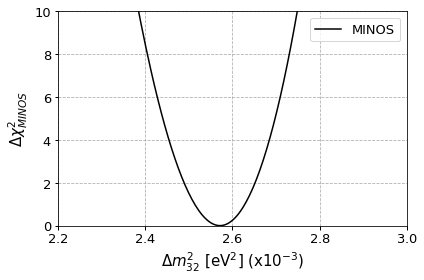

In [6]:
MINOS_dm32=ploter_MINOS_profile(minos_data,'dm32',1000)

In [7]:
hols = get_total_uncertainties(MINOS_dm32,'dm32')
d1 = hols[0]
d2 = hols[1]
for k in range(0,len(d2)):
    print(d1[k], d2[k])

0.001 731.7968246088113
0.001003903903903904 728.1100388057496
0.0010078078078078077 724.4277142112041
0.0010117117117117117 720.7499400075832
0.0010156156156156157 717.0768053772949
0.0010195195195195196 713.4083995027477
0.0010234234234234234 709.7448115663503
0.0010273273273273273 706.0861307505106
0.0010312312312312313 702.4324462376367
0.0010351351351351352 698.7838472101375
0.001039039039039039 695.1404228504213
0.001042942942942943 691.5022623408959
0.001046846846846847 687.8694548639696
0.0010507507507507507 684.2420896020516
0.0010546546546546546 680.6202557375494
0.0010585585585585586 677.0040424528714
0.0010624624624624626 673.393538930426
0.0010663663663663663 669.788834352622
0.0010702702702702703 666.1900179018669
0.0010741741741741742 662.5971787605694
0.0010780780780780782 659.010406111138
0.001081981981981982 655.4297891359809
0.0010858858858858859 651.8554170175063
0.0010897897897897899 648.2873789381224
0.0010936936936936938 644.7257640802378
0.0010975975975975976 64

In [8]:
# Incertidumbres de MINOS
MIN_MINOS= 0.0026
val_left = 0.00251081081081
val_right= 0.00263183183183
print(MIN_MINOS-val_left,val_right-MIN_MINOS)

8.918918918999997e-05 3.183183183000024e-05


{'dm32_min': 0.0026, 's2_t13_min': 0.0, 's2_t23_min': 0.375, 'ji_min': 0.0}
{'new_min_after_interpolation': 0.0, 'min_nom_arfter_interp': 0.0}


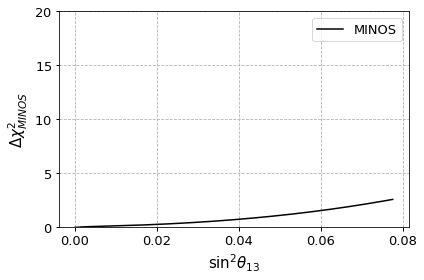

In [9]:
MINOS_s2_t13=ploter_MINOS_profile(minos_data,'s2_t13',1000)

{'dm32_min': 0.0026, 's2_t13_min': 0.0, 's2_t23_min': 0.375, 'ji_min': 0.0}
{'new_min_after_interpolation': -0.0012631162732977992, 'min_nom_arfter_interp': 0.0}


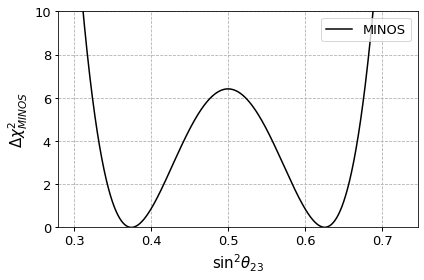

In [10]:
MINOS_s2_t23=ploter_MINOS_profile(minos_data,'s2_t23',1000)

In [11]:
hols = get_total_uncertainties(MINOS_s2_t23,'s2_t23')
d1 = hols[0]
d2 = hols[1]
for k in range(0,len(d2)):
    print(d1[k], d2[k])

0.3 14.945648086273293
0.30042542542542544 14.736048323634689
0.30085085085085084 14.528360537587865
0.3012762762762763 14.322576010760814
0.3017017017017017 14.118686025781662
0.30212712712712714 13.916681865278411
0.30255255255255253 13.716554811879172
0.302977977977978 13.518296148211947
0.3034034034034034 13.321897156904855
0.30382882882882883 13.127349120585906
0.30425425425425423 12.934643321883202
0.3046796796796797 12.743771043424758
0.3051051051051051 12.554723567838684
0.30553053053053053 12.367492177752986
0.3059559559559559 12.18206815579577
0.3063813813813814 11.998442784595055
0.3068068068068068 11.816607346778943
0.3072322322322322 11.636553124975446
0.3076576576576576 11.458271401812675
0.3080830830830831 11.28175345991864
0.30850850850850847 11.106990581921444
0.3089339339339339 10.933974050449105
0.3093593593593593 10.762695148129726
0.3097847847847848 10.59314515759132
0.3102102102102102 10.425315361461973
0.3106356356356356 10.25919704236976
0.3110610610610611 10.09

In [12]:
# Incertidumbres de MINOS
MIN_MINOS= 0.375
val_left = 0.35105105105105106
val_right= 0.40210210210210207
print(MIN_MINOS-val_left,val_right-MIN_MINOS)

0.023948948948948945 0.027102102102102066


# MINOS  - ( 2D vs $\Delta \chi^2$)

In [22]:
def ploter_MINOS_confidence_regions(df,params,size):
    
    df = get_interpolated_data_2D(df,params,size)
    
    cl_68 = df[ (df['ji']  <=  2.30) & (df['ji']  >=  2.15) ]    
    cl_90 = df[ (df['ji']  <=  4.61) & (df['ji']  >=  4.51) ]
    
    fig, ax = plt.subplots(figsize=(9,6))
    
    par =[]
    labels = []    
        
    if( ('dm32' in params) & ('s2_t13' in params) ):
        par.append('s2_t13')
        par.append('dm32')
        
        ax.set_xlim(0., 0.08)
        ax.set_xticks([0.,0.02,0.04,0.06,0.08])
        ax.set_xticklabels(['$0.0$','$0.02$','$0.04$','$0.06$','$0.08$'])
        
        ax.set_ylim(0.002, 0.003)   
        ax.set_yticks([0.002,0.0022,0.0024,0.0026,0.0028,0.003])
        ax.set_yticklabels(['$2.0$','$2.2$','$2.4$','$2.6$','$2.8$','$3.0$'])
        labels = [r'$\sin^2 \theta_{13}$',r'$\Delta m^2_{32}$'+' [eV$^2$] (x10$^{-3}$)']        
        
        
        ax.scatter(par[0], par[1], data=cl_90, c='black',s=0.5, label='90% C.L.')
        ax.scatter(par[0], par[1], data=cl_68, c='darkcyan',s=0.5, label='68% C.L.')
        ax.tick_params(labelcolor='black', labelsize=13, width=1)
        lgnd=ax.legend()
        lgnd = plt.legend(loc="upper right", scatterpoints=1, fontsize=15)
    
        lgnd.legendHandles[0]._sizes = [50]
        lgnd.legendHandles[1]._sizes = [50]
        #lgnd.legendHandles[2]._sizes = [50]        
        
    elif( ('dm32' in params) & ('s2_t23' in params) ):
        par.append('s2_t23')
        par.append('dm32')
        
        ax.scatter(0.375,0.0026,c='red',marker='+' ,s=150,label='Our best fit')
        
        labels = [r'$\sin^2 \theta_{23}$',r'$\Delta m^2_{32}$'+' [eV$^2$] (x10$^{-3}$)']
        #ax.set_xlim(0.2, 0.8)
        #ax.set_xticks([0.2,0.4,0.6,0.8])
        #ax.set_xticklabels(['$0.2$','$0.4$','$0.6$','$0.8$'])
        
        ax.set_ylim(0.002, 0.0030)   
        ax.set_yticks([0.002,0.0022,0.0024,0.0026,0.0028,0.003,0.0032])
        ax.set_yticklabels(['$2.0$','$2.2$','$2.4$','$2.6$','$2.8$','$3.0$','$3.2$'])
        
        ax.scatter(par[0], par[1], data=cl_90, c='black',s=0.5, label='90% C.L.')
        ax.scatter(par[0], par[1], data=cl_68, c='darkcyan',s=0.5, label='68% C.L.')
        ax.tick_params(labelcolor='black', labelsize=13, width=1)
        lgnd=ax.legend()
        lgnd = plt.legend(loc="upper right", scatterpoints=1, fontsize=15)
    
        lgnd.legendHandles[0]._sizes = [50]
        lgnd.legendHandles[1]._sizes = [50]        
        lgnd.legendHandles[2]._sizes = [50]        
    elif( ('s2_t13' in params) & ('s2_t23' in params) ):
        par.append('s2_t13')
        par.append('s2_t23')
        ax.set_xlim(0., 0.08)
        ax.set_xticks([0.,0.02,0.04,0.06,0.08])
        ax.set_xticklabels(['$0.0$','$0.02$','$0.04$','$0.06$','$0.08$'])
        labels = [r'$\sin^2 \theta_{13}$',r'$\sin^2 \theta_{23}$']
        
        
        ax.scatter(par[0], par[1], data=cl_90, c='black',s=0.5, label='90% C.L.')
        ax.scatter(par[0], par[1], data=cl_68, c='darkcyan',s=0.5, label='68% C.L.')
        ax.tick_params(labelcolor='black', labelsize=13, width=1)
        lgnd=ax.legend()
        lgnd = plt.legend(loc="upper right", scatterpoints=1, fontsize=15)
    
        lgnd.legendHandles[0]._sizes = [50]
        lgnd.legendHandles[1]._sizes = [50]        
    else:
        print('Opción no correcta')
        
    
    
    
    ax.set(xlabel=labels[0], ylabel=labels[1],  title='MINOS')
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)
    
   
    
    ax.grid(True,linestyle='--')
    fig.savefig('images/plot_MINOS_'+par[0]+'_'+par[1]+ '_vs_ji.png')
    return [cl_68,cl_90]

{'dm32_min': 0.0026, 's2_t13_min': 0.0, 's2_t23_min': 0.375, 'ji_min': 0.0}
{'new_min_after_interpolation': -0.30928929022984664, 'min_nom_arfter_interp': 0.0}


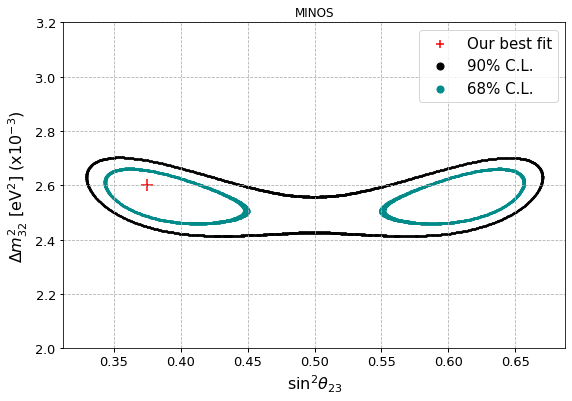

In [23]:
MINOS_dm32_s2_t23=ploter_MINOS_confidence_regions(minos_data,['dm32','s2_t23'],2800)

{'dm32_min': 0.0026, 's2_t13_min': 0.0, 's2_t23_min': 0.375, 'ji_min': 0.0}
{'new_min_after_interpolation': -0.24469186652555613, 'min_nom_arfter_interp': 0.0}


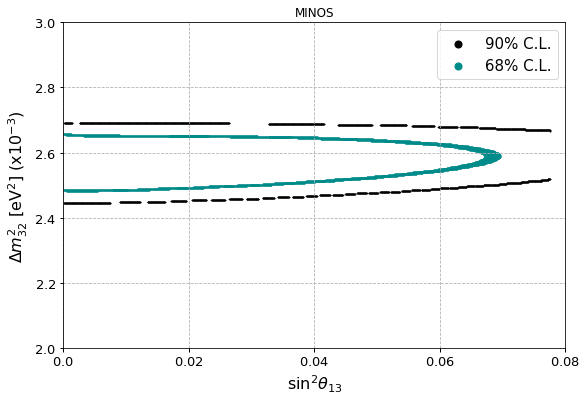

In [26]:
MINOS_dm32_s2_t13=ploter_MINOS_confidence_regions(minos_data,['s2_t13','dm32'],2000)

{'dm32_min': 0.0026, 's2_t13_min': 0.0, 's2_t23_min': 0.375, 'ji_min': 0.0}
{'new_min_after_interpolation': -0.001263116273297775, 'min_nom_arfter_interp': 0.0}


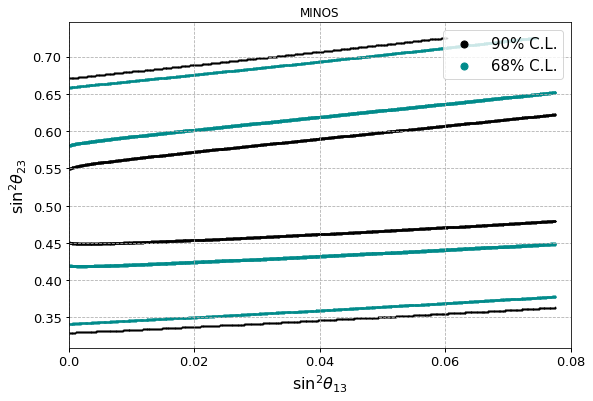

In [25]:
MINOS_s2_t13_s2_t23=ploter_MINOS_confidence_regions(minos_data,['s2_t23','s2_t13'],1000)

# SK  - ( 1D vs $\Delta \chi^2$)

In [27]:
def ploter_SK_profile(df,param,size):
    r = get_interpolated_data_1D(df,param,size)
    
    fig, ax = plt.subplots(figsize=(9,6))
    ax.plot(param, 'ji', data=r,label='Super-Kamiokande',c='black')
    lgnd = plt.legend(loc="upper right",fontsize=13)
    
    labels=[]    
    if(param=='dm32'):
        ax.set_xlim(0.001, 0.005)
        ax.set_xticks([0.001,0.002,0.003,0.004,0.005])
        ax.set_xticklabels(['$1.0$','$2.0$','$3.0$','$4.0$','$5.0$'])
        
        ax.set_ylim(0, 20)   
        ax.set_yticks([0,5,10,15,20])
        ax.set_yticklabels(['$0$','$5$','$10$','$15$','$20$'])
        
        labels=[r'$\Delta m^2_{32}$ [eV$^2$] (x10$^{-3}$)',r'$\Delta \chi^2 $']
    elif(param=='s2_t13'):
        ax.set_ylim(0, 20)   
        ax.set_yticks([0,5,10,15,20])
        ax.set_yticklabels(['$0$','$5$','$10$','$15$','$20$'])
        
        ax.set_xlim(0.00, 0.07)
        ax.set_xticks([0.00,0.01,0.02,0.03,0.04,0.05,0.06,0.07])
        ax.set_xticklabels(['$0.0$','$0.01$','$0.02$','$0.03$','$0.04$','$0.05$','$0.06$','$0.07$'])
        
        labels=[r'$\sin^2 \theta_{13}$',r'$\Delta \chi^2 $']
    elif(param=='s2_t23'):
        ax.set_ylim(0, 20)   
        ax.set_yticks([0,5,10,15,20])
        ax.set_yticklabels(['$0$','$5$','$10$','$15$','$20$'])
        
        labels=[r'$\sin^2 \theta_{23}$',r'$\Delta \chi^2 $']
    else:
        print('Opción no de "param" es incorrecta')
        
    ax.tick_params(labelcolor='black', labelsize=14, width=1)
    
    ax.set(xlabel=labels[0], ylabel=labels[1])
    ax.xaxis.label.set_size(15)
    ax.yaxis.label.set_size(15)
    plt.tight_layout()
    ax.grid(True, linestyle='--')
    
    fig.savefig('images/plot_SK_'+param+'_vs_ji.png')
    return r

{'dm32_min': 0.0024, 's2_t13_min': 0.01, 's2_t23_min': 0.55, 'ji_min': 0.0}
{'new_min_after_interpolation': -0.06876586221230677, 'min_nom_arfter_interp': 0.0}


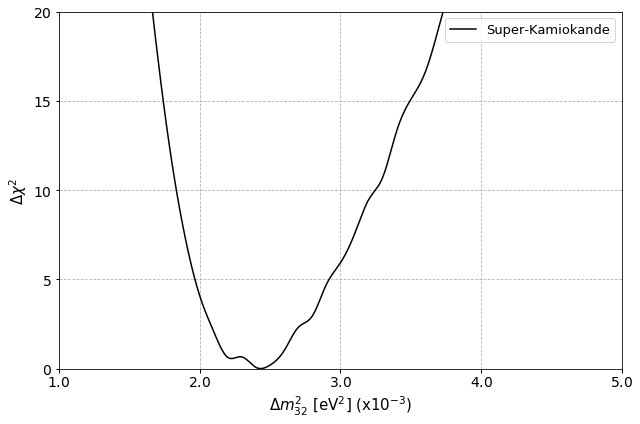

In [34]:
SK_dm32=ploter_SK_profile(sk_data,'dm32',200)

{'dm32_min': 0.0024, 's2_t13_min': 0.01, 's2_t23_min': 0.55, 'ji_min': 0.0}
{'new_min_after_interpolation': -0.006523855811921742, 'min_nom_arfter_interp': 0.0}


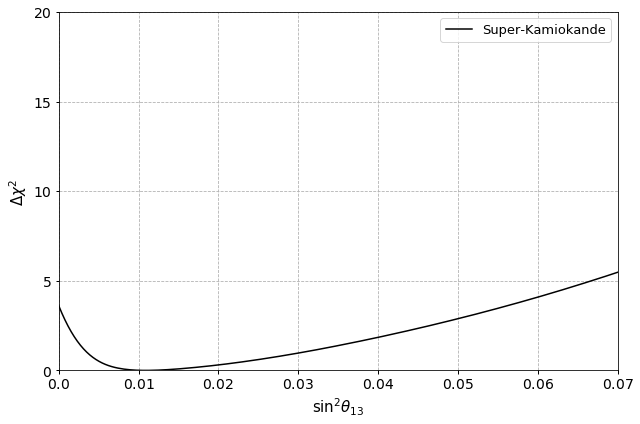

In [35]:
SK_s2_t13=ploter_SK_profile(sk_data,'s2_t13',200)

{'dm32_min': 0.0024, 's2_t13_min': 0.01, 's2_t23_min': 0.55, 'ji_min': 0.0}
{'new_min_after_interpolation': -0.004879884118292916, 'min_nom_arfter_interp': 0.0}


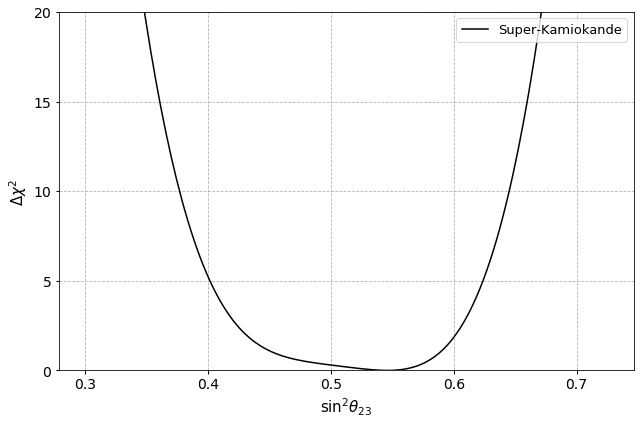

In [36]:
SK_s2_t23=ploter_SK_profile(sk_data,'s2_t23',200)

# SK  - ( 2D vs $\Delta \chi^2$)

In [146]:
def ploter_SK_confidence_regions(df,params,size):
    
    df = get_interpolated_data_2D(df,params,size)
    
    cl_68 = df[ (df['ji']  <=  2.30)  & (df['ji']  >=  2.25) ]   # 68.27 C.L. 
    cl_90 = df[ (df['ji']  <=  4.61)  & (df['ji']  >=  4.56) ]
    #cl_95 = df[ (df['ji']  <=  6.18)  & (df['ji']  >=  6.08) ]   # 95.45 C.L.
    #cl_99 = df[ (df['ji']  <=  11.83) & (df['ji']  >=  11.73) ]  # 99.73 C.L.
    
        
    fig, ax = plt.subplots(figsize=(9,6))
    
    par =[]
    labels = []    
    if( ('dm32' in params) & ('s2_t13' in params) ):
        par.append('s2_t13')
        par.append('dm32')
        ax.set_xlim(0.0, 0.07)
        ax.set_xticks([0.,0.02,0.04,0.06])
        ax.set_xticklabels(['$0.0$','$0.02$','$0.04$','$0.06$'])
        
        ax.set_ylim(0.0015, 0.0035)   
        ax.set_yticks([0.0015,0.0020,0.0025,0.0030,0.0035])
        ax.set_yticklabels(['$1.5$','$2.0$','$2.5$','$3.0$','$3.5$'])
        labels = [r'$\sin^2 \theta_{13}$',r'$\Delta m^2_{32}$'+' [eV$^2$] (x10$^{-3}$)']        
    elif( ('dm32' in params) & ('s2_t23' in params) ):
        par.append('s2_t23')
        par.append('dm32')        
        #ax.set_xlim(0.2, 0.8)
        #ax.set_xticks([0.2,0.4,0.6,0.8])
        #ax.set_xticklabels(['$0.2$','$0.4$','$0.6$','$0.8$'])
        
        ax.set_ylim(0.0015, 0.0035)   
        ax.set_yticks([0.0015,0.0020,0.0025,0.0030,0.0035])
        ax.set_yticklabels(['$1.5$','$2.0$','$2.5$','$3.0$','$3.5$'])
        
        labels = [r'$\sin^2 \theta_{23}$',r'$\Delta m^2_{32}$'+' [eV$^2$] (x10$^{-3}$)']
    elif( ('s2_t13' in params) & ('s2_t23' in params) ):
        par.append('s2_t13')
        par.append('s2_t23')
        ax.set_xlim(0.0, 0.07)
        ax.set_xticks([0.,0.02,0.04,0.06])
        ax.set_xticklabels(['$0.0$','$0.02$','$0.04$','$0.06$'])
        
        ax.set_ylim(0.3, 0.7)
        ax.set_yticks([0.30,0.40,0.5,0.60,0.70])
        ax.set_yticklabels(['$3.0$','$4.0$','$5.0$','$6.0$','$7.0$'])
        
        labels = [r'$\sin^2 \theta_{13}$',r'$\sin^2 \theta_{23}$']
    else:
        print('Opción no correcta')
    
    #ax.scatter(par[0], par[1], data=cl_99, c='black',s=0.5)
    #ax.scatter(par[0], par[1], data=cl_95, c='red',s=0.5)    
    ax.scatter(par[0], par[1], data=cl_90, c='black',s=0.5)
    ax.scatter(par[0], par[1], data=cl_68, c='blue',s=0.5)
    
    ax.set(xlabel=labels[0], ylabel=labels[1],  title='Super-Kamiokande')
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)
    
    ax.tick_params(labelcolor='black', labelsize=13, width=1)
    
    ax.grid(True,linestyle='--')
    fig.savefig('images/plot_SK_'+par[0]+'_'+par[1]+ '_vs_ji.png')
    #return [cl_68,cl_95,cl_99]
    return [cl_68,cl_90]

{'dm32_min': 0.0024, 's2_t13_min': 0.01, 's2_t23_min': 0.55, 'ji_min': 0.0}
{'new_min_after_interpolation': -0.07080532905839214, 'min_nom_arfter_interp': 0.0}


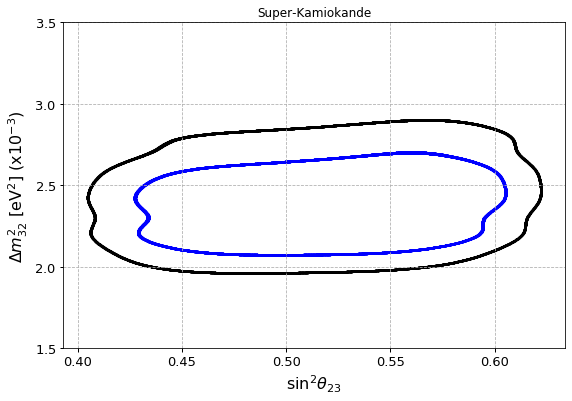

In [147]:
SK_dm32_s2_t23=ploter_SK_confidence_regions(sk_data,['dm32','s2_t23'],5000)

{'dm32_min': 0.0024, 's2_t13_min': 0.01, 's2_t23_min': 0.55, 'ji_min': 0.0}
{'new_min_after_interpolation': -0.08106920950675915, 'min_nom_arfter_interp': 0.0}


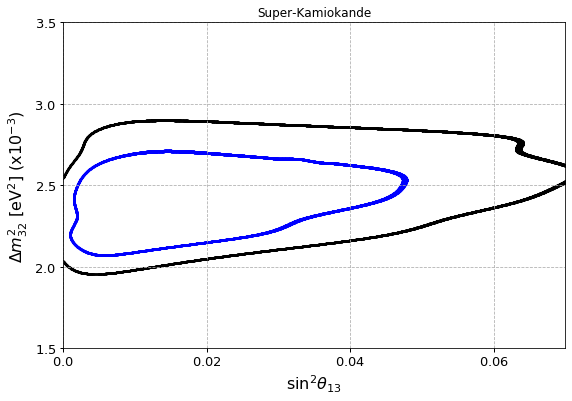

In [148]:
SK_dm32_s2_t13=ploter_SK_confidence_regions(sk_data,['dm32','s2_t13'],3500)

{'dm32_min': 0.0024, 's2_t13_min': 0.01, 's2_t23_min': 0.55, 'ji_min': 0.0}
{'new_min_after_interpolation': -0.013411456886477359, 'min_nom_arfter_interp': 0.0}


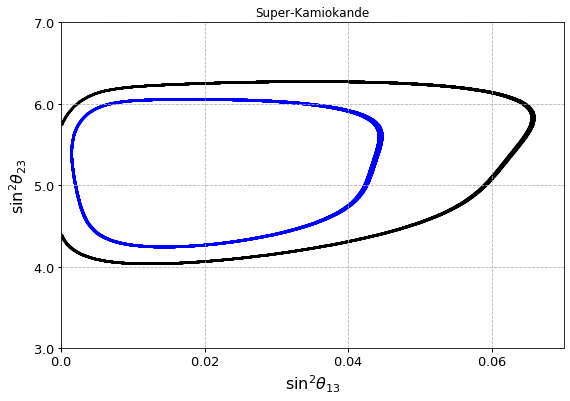

In [149]:
SK_s2_t13_s2_t23=ploter_SK_confidence_regions(sk_data,['s2_t13','s2_t23'],3500)

# Daya Bay  - ( 1D vs $\Delta \chi^2$)

In [41]:
def ploter_DB_profile(df,param,size):
    r = get_interpolated_data_1D(df,param,size)
    
    fig, ax = plt.subplots(figsize=(9,6))
    ax.plot(param, 'ji', data=r,label='Daya Bay',c='black')
    lgnd = plt.legend(loc="upper right",fontsize=13)
    
    labels=[]    
    if(param=='dm32'):
        ax.set_xlim(0.002, 0.003)
        ax.set_xticks([0.002,0.0022,0.0024,0.0026,0.0028,0.003])
        ax.set_xticklabels(['$2.0$','$2.2$','$2.4$','$2.6$','$2.8$','$3.0$'])
        
        ax.set_ylim(0, 12)
        ax.set_yticks([0,2,4,6,8,10,12])
        ax.set_yticklabels(['$0$','$2$','$4$','$6$','$8$','$10$','$12$'])
        
        labels=[r'$\Delta m^2_{32}$ [eV$^2$] (x10$^{-3}$)',r'$\Delta \chi^2 $']
    elif(param=='s2_t13'):
        ax.set_ylim(0, 12)   
        ax.set_yticks([0,2,4,6,8,10,12])
        ax.set_yticklabels(['$0$','$2$','$4$','$6$','$8$','$10$','$12$'])
        
        ax.set_xlim(0.015, 0.03)
        ax.set_xticks([0.015,0.020,0.025,0.030])
        ax.set_xticklabels(['$0.015$','$0.020$','$0.025$','$0.030$'])
        
        labels=[r'$\sin^2 \theta_{13}$',r'$\Delta \chi^2 $']
    elif(param=='s2_t23'):
        #ax.set_ylim(0, 20)   
       #ax.set_yticks([0,5,10,15,20])
       # ax.set_yticklabels(['$0$','$5$','$10$','$15$','$20$'])
        
        labels=[r'$\sin^2 \theta_{23}$',r'$\Delta \chi^2 $']
    else:
        print('Opción no de "param" es incorrecta')
        
    ax.tick_params(labelcolor='black', labelsize=14, width=1)
    
    ax.set(xlabel=labels[0], ylabel=labels[1])
    ax.xaxis.label.set_size(15)
    ax.yaxis.label.set_size(15)
    plt.tight_layout()
    ax.grid(True, linestyle='--')
    
    fig.savefig('images/plot_DB_'+param+'_vs_ji.png')
    return r

{'dm32_min': 0.0025, 's2_t13_min': 0.0225, 's2_t23_min': 0.3, 'ji_min': 151.88171892459937}
{'new_min_after_interpolation': -0.5906171822126629, 'min_nom_arfter_interp': 0.0}


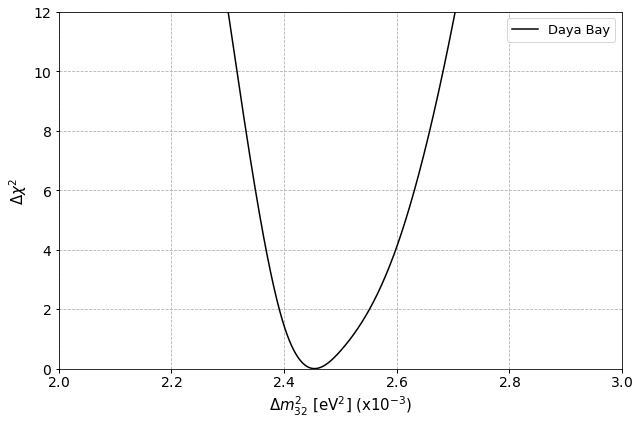

In [42]:
db_dm32=ploter_DB_profile(db_data,'dm32',5000)

{'dm32_min': 0.0025, 's2_t13_min': 0.0225, 's2_t23_min': 0.3, 'ji_min': 0.0}
{'new_min_after_interpolation': -0.35490986235052335, 'min_nom_arfter_interp': 0.0}


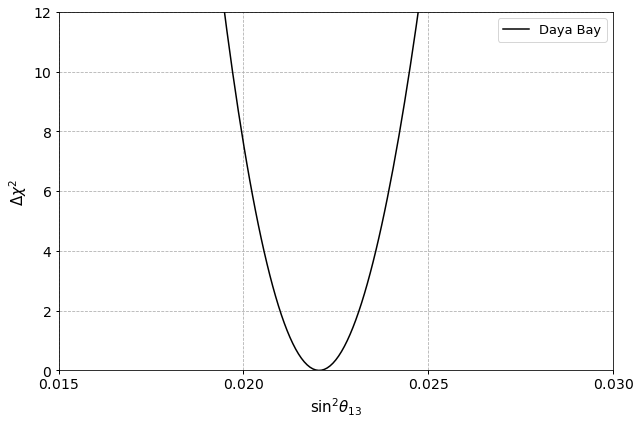

In [43]:
db_s2_t13=ploter_DB_profile(db_data,'s2_t13',1000)

{'dm32_min': 0.0025, 's2_t13_min': 0.0225, 's2_t23_min': 0.3, 'ji_min': 0.0}
{'new_min_after_interpolation': 0.0, 'min_nom_arfter_interp': 0.0}


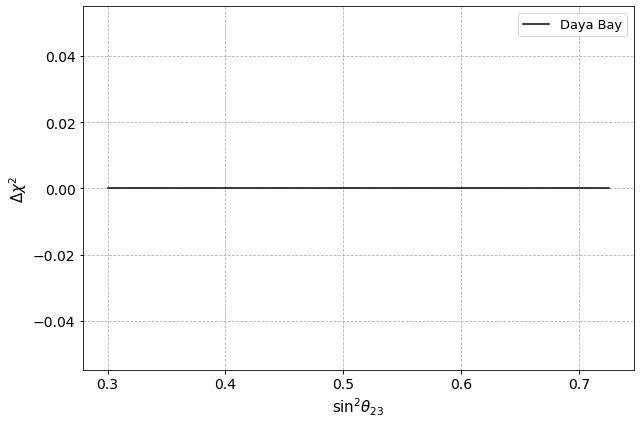

In [47]:
db_s2_t23=ploter_DB_profile(db_data,'s2_t23',1000)

# Daya Bay  - ( 2D vs $\Delta \chi^2$)

In [48]:
def ploter_DB_confidence_regions(df,params,size):
    
    df = get_interpolated_data_2D(df,params,size)
    
    cl_68 = df[ (df['ji']  <=  2.30)  & (df['ji']  >=  2.15) ]   # 68.27 C.L. 
    cl_90 = df[ (df['ji']  <=  4.61)  & (df['ji']  >=  4.51) ]
    cl_95 = df[ (df['ji']  <=  6.18)  & (df['ji']  >=  6.05) ]   # 95.45 C.L.
    cl_99 = df[ (df['ji']  <=  11.83) & (df['ji']  >=  11.65) ]  # 99.73 C.L.
    
    fig, ax = plt.subplots(figsize=(9,6))
    
    par =[]
    labels = []    
    if( ('dm32' in params) & ('s2_t13' in params) ):
        par.append('s2_t13')
        par.append('dm32')
        #ax.set_xlim(0.0, 0.07)
        #ax.set_xticks([0.,0.02,0.04,0.06])
        #ax.set_xticklabels(['$0.0$','$0.02$','$0.04$','$0.06$'])
        
        ax.set_ylim(0.002, 0.0030)   
        ax.set_yticks([0.002,0.0022,0.0024,0.0026,0.0028,0.0030])
        ax.set_yticklabels(['$2.0$','$2.2$','$2.4$','$2.6$','$2.8$','$3.0$'])
        labels = [r'$\sin^2 \theta_{13}$',r'$\Delta m^2_{32}$'+' [eV$^2$] (x10$^{-3}$)']        
    elif( ('dm32' in params) & ('s2_t23' in params) ):
        par.append('s2_t23')
        par.append('dm32')        
        
        labels = [r'$\sin^2 \theta_{23}$',r'$\Delta m^2_{32}$'+' [eV$^2$] (x10$^{-3}$)']
    elif( ('s2_t13' in params) & ('s2_t23' in params) ):
        par.append('s2_t13')
        par.append('s2_t23')        
        
        labels = [r'$\sin^2 \theta_{13}$',r'$\sin^2 \theta_{23}$']
    else:
        print('Opción no correcta')
    
    #ax.scatter(par[0], par[1], data=cl_99, c='black',s=0.5)
    #ax.scatter(par[0], par[1], data=cl_95, c='red',s=0.5)    
    ax.scatter(par[0], par[1], data=cl_90, c='black',s=0.5)
    ax.scatter(par[0], par[1], data=cl_68, c='blue',s=0.5)
    
    ax.set(xlabel=labels[0], ylabel=labels[1],  title='Daya Bay')
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)
    
    ax.tick_params(labelcolor='black', labelsize=13, width=1)
    
    ax.grid(True,linestyle='--')
    fig.savefig('images/plot_DB_'+par[0]+'_'+par[1]+ '_vs_ji.png')
    #return [cl_68,cl_95,cl_99]
    return [cl_68,cl_90]

{'dm32_min': 0.0025, 's2_t13_min': 0.0225, 's2_t23_min': 0.3, 'ji_min': 0.0}
{'new_min_after_interpolation': -0.5891995955963927, 'min_nom_arfter_interp': 0.0}


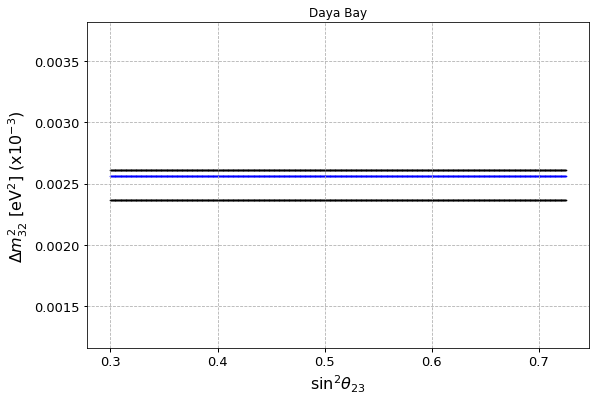

In [49]:
db_dm32_s2_t23=ploter_DB_confidence_regions(db_data,['dm32','s2_t23'],1000)

{'dm32_min': 0.0025, 's2_t13_min': 0.0225, 's2_t23_min': 0.3, 'ji_min': 0.0}
{'new_min_after_interpolation': -0.8541988528293458, 'min_nom_arfter_interp': 0.0}


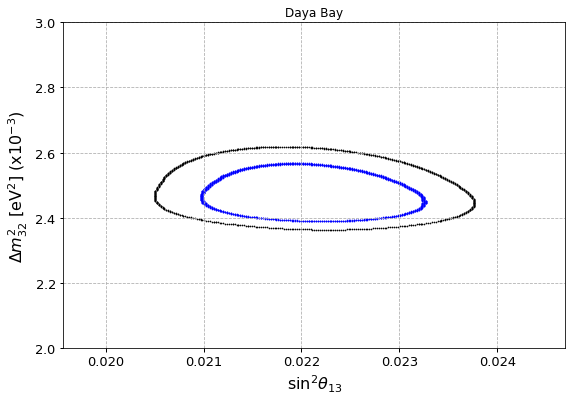

In [50]:
db_dm32_s2_t13=ploter_DB_confidence_regions(db_data,['dm32','s2_t13'],4000)

{'dm32_min': 0.0025, 's2_t13_min': 0.0225, 's2_t23_min': 0.3, 'ji_min': 0.0}
{'new_min_after_interpolation': -0.35490986235052485, 'min_nom_arfter_interp': 0.0}


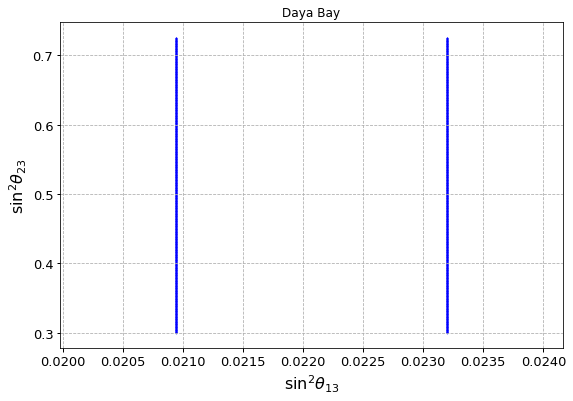

In [51]:
db_s2_t13_s2_t23=ploter_DB_confidence_regions(db_data,['s2_t23','s2_t13'],1000)

# RENO  - ( 1D vs $\Delta \chi^2$)

In [52]:
def ploter_RENO_profile(df,param,size):
    r = get_interpolated_data_1D(df,param,size)
    
    fig, ax = plt.subplots(figsize=(9,6))
    ax.plot(param, 'ji', data=r,label='RENO',c='black')
    lgnd = plt.legend(loc="upper right",fontsize=13)
    
    labels=[]    
    if(param=='dm32'):
        ax.set_xlim(0.002, 0.0035)
        ax.set_xticks([0.002,0.0022,0.0024,0.0026,0.0028,0.003,0.0032,0.0034])
        ax.set_xticklabels(['$2.0$','$2.2$','$2.4$','$2.6$','$2.8$','$3.0$','$3.2$','$3.4$'])
        
        ax.set_ylim(0, 12)
        ax.set_yticks([0,2,4,6,8,10,12])
        ax.set_yticklabels(['$0$','$2$','$4$','$6$','$8$','$10$','$12$'])
        
        labels=[r'$\Delta m^2_{32}$ [eV$^2$] (x10$^{-3}$)',r'$\Delta \chi^2 $']
    elif(param=='s2_t13'):
        ax.set_ylim(0, 12)   
        ax.set_yticks([0,2,4,6,8,10,12])
        ax.set_yticklabels(['$0$','$2$','$4$','$6$','$8$','$10$','$12$'])
        
        ax.set_xlim(0.015, 0.03)
        ax.set_xticks([0.015,0.020,0.025,0.030])
        ax.set_xticklabels(['$0.015$','$0.020$','$0.025$','$0.030$'])
        
        labels=[r'$\sin^2 \theta_{13}$',r'$\Delta \chi^2 $']
    elif(param=='s2_t23'):
        #ax.set_ylim(0, 20)   
       #ax.set_yticks([0,5,10,15,20])
       # ax.set_yticklabels(['$0$','$5$','$10$','$15$','$20$'])
        
        labels=[r'$\sin^2 \theta_{23}$',r'$\Delta \chi^2 $']
    else:
        print('Opción no de "param" es incorrecta')
        
    ax.tick_params(labelcolor='black', labelsize=14, width=1)
    
    ax.set(xlabel=labels[0], ylabel=labels[1])
    ax.xaxis.label.set_size(15)
    ax.yaxis.label.set_size(15)
    plt.tight_layout()
    ax.grid(True, linestyle='--')
    
    fig.savefig('images/plot_RENO_'+param+'_vs_ji.png')
    return  r

{'dm32_min': 0.0027, 's2_t13_min': 0.0225, 's2_t23_min': 0.3, 'ji_min': 16.69100275212546}
{'new_min_after_interpolation': -4.491901009585908e-05, 'min_nom_arfter_interp': 0.0}


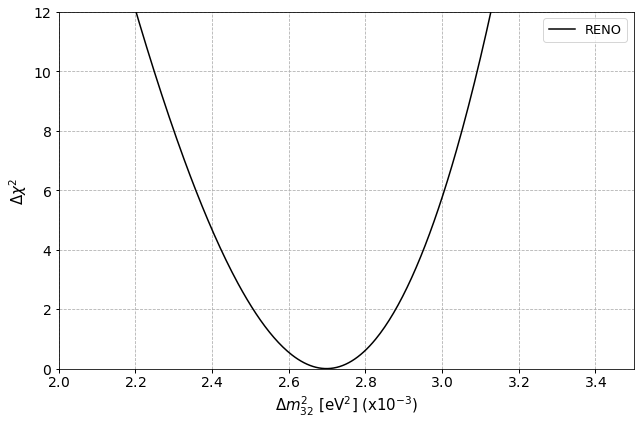

In [53]:
RENO_dm32 = ploter_RENO_profile(reno_data,'dm32',1000)

{'dm32_min': 0.0027, 's2_t13_min': 0.0225, 's2_t23_min': 0.3, 'ji_min': 0.0}
{'new_min_after_interpolation': -0.034973846046263864, 'min_nom_arfter_interp': 0.0}


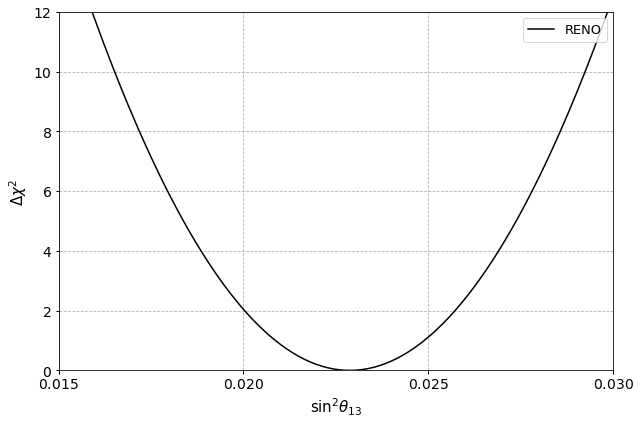

In [54]:
RENO_s2_t13 = ploter_RENO_profile(reno_data,'s2_t13',1000)

{'dm32_min': 0.0027, 's2_t13_min': 0.0225, 's2_t23_min': 0.3, 'ji_min': 0.0}
{'new_min_after_interpolation': 0.0, 'min_nom_arfter_interp': 0.0}


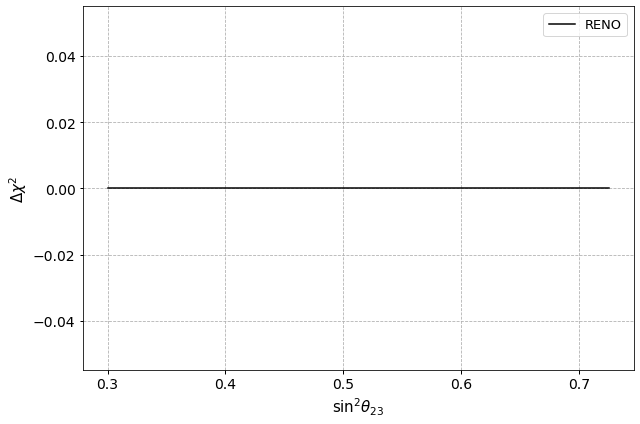

In [55]:
RENO_s2_t23 = ploter_RENO_profile(reno_data,'s2_t23',1000)

# RENO  - ( 2D vs $\Delta \chi^2$)

In [56]:
def ploter_RENO_confidence_regions(df,params,size):
    
    df = get_interpolated_data_2D(df,params,size)
    
    cl_68 = df[ (df['ji']  <=  2.30)  & (df['ji']  >=  2.2) ]   # 68.27 C.L. 
    cl_90 = df[ (df['ji']  <=  4.61)  & (df['ji']  >=  4.51) ]
    cl_95 = df[ (df['ji']  <=  6.18)  & (df['ji']  >=  6.05) ]   # 95.45 C.L.
    cl_99 = df[ (df['ji']  <=  11.83) & (df['ji']  >=  11.65) ]  # 99.73 C.L.
    
    fig, ax = plt.subplots(figsize=(9,6))
    
    par =[]
    labels = []    
    if( ('dm32' in params) & ('s2_t13' in params) ):
        par.append('s2_t13')
        par.append('dm32')
        ax.set_xlim(0.015, 0.032)
        #ax.set_xticks([0.,0.02,0.04,0.06])
        #ax.set_xticklabels(['$0.0$','$0.02$','$0.04$','$0.06$'])
        
        ax.set_ylim(0.002, 0.0035)   
        ax.set_yticks([0.002,0.0025,0.0030,0.0035])
        ax.set_yticklabels(['$2.0$','$2.5$','$3.0$','$3.5$'])
        labels = [r'$\sin^2 \theta_{13}$',r'$\Delta m^2_{32}$'+' [eV$^2$] (x10$^{-3}$)']        
    elif( ('dm32' in params) & ('s2_t23' in params) ):
        par.append('s2_t23')
        par.append('dm32')        
        
        labels = [r'$\sin^2 \theta_{23}$',r'$\Delta m^2_{32}$'+' [eV$^2$] (x10$^{-3}$)']
    elif( ('s2_t13' in params) & ('s2_t23' in params) ):
        par.append('s2_t13')
        par.append('s2_t23')        
        
        labels = [r'$\sin^2 \theta_{13}$',r'$\sin^2 \theta_{23}$']
    else:
        print('Opción no correcta')
    
    #ax.scatter(par[0], par[1], data=cl_99, c='black',s=0.5)
    #ax.scatter(par[0], par[1], data=cl_95, c='red',s=0.5)    
    ax.scatter(par[0], par[1], data=cl_90, c='black',s=0.5)
    ax.scatter(par[0], par[1], data=cl_68, c='blue',s=0.5)
    
    ax.set(xlabel=labels[0], ylabel=labels[1],  title='RENO')
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)
    
    ax.tick_params(labelcolor='black', labelsize=13, width=1)
    
    ax.grid(True,linestyle='--')
    fig.savefig('images/plot_RENO_'+par[0]+'_'+par[1]+ '_vs_ji.png')
    #return [cl_68,cl_95,cl_99]
    return [cl_68,cl_90]

{'dm32_min': 0.0027, 's2_t13_min': 0.0225, 's2_t23_min': 0.3, 'ji_min': 0.0}
{'new_min_after_interpolation': -4.4919010095934744e-05, 'min_nom_arfter_interp': 0.0}


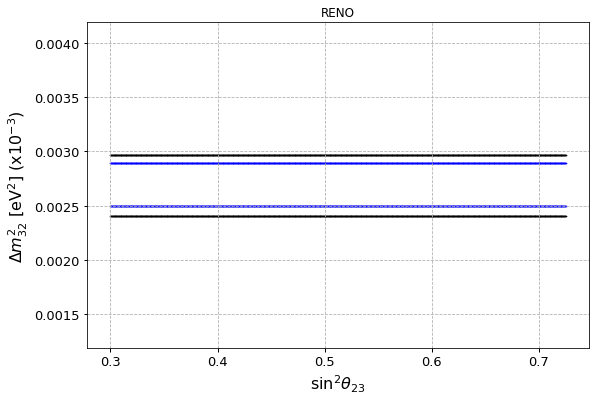

In [57]:
RENO_dm32_s2_t23 = ploter_RENO_confidence_regions(reno_data,['dm32','s2_t23'],1000)

{'dm32_min': 0.0027, 's2_t13_min': 0.0225, 's2_t23_min': 0.3, 'ji_min': 0.0}
{'new_min_after_interpolation': -0.0422337802419347, 'min_nom_arfter_interp': 0.0}


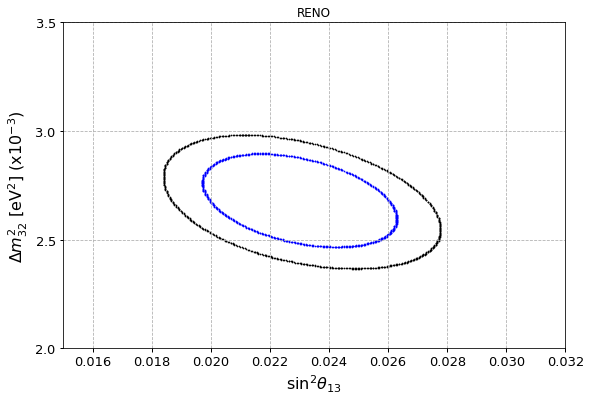

In [58]:
RENO_dm32_s2_t13 = ploter_RENO_confidence_regions(reno_data,['dm32','s2_t13'],1500)

{'dm32_min': 0.0027, 's2_t13_min': 0.0225, 's2_t23_min': 0.3, 'ji_min': 0.0}
{'new_min_after_interpolation': -0.034973846046263975, 'min_nom_arfter_interp': 0.0}


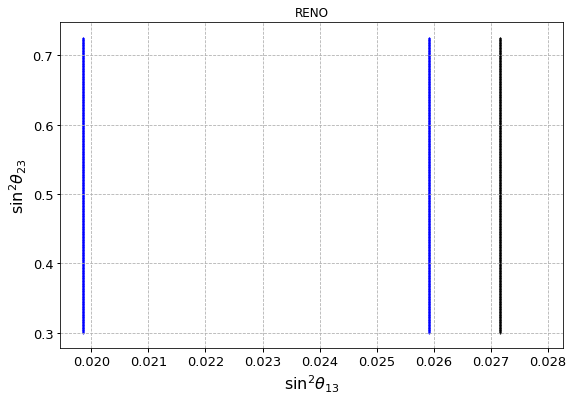

In [59]:
RENO_s2_t13_s2_t23 = ploter_RENO_confidence_regions(reno_data,['s2_t23','s2_t13'],1000)

# Análisis unificado

In [60]:
#sk_data,reno_data,minos_data,db_data
sum_ji = sk_data['ji']+reno_data['ji']+minos_data['ji']+db_data['ji']
print((sk_data['ji'].min(),reno_data['ji'].min(),minos_data['ji'].min(),db_data['ji'].min()))
print((sk_data['ji'].min()+reno_data['ji'].min()+minos_data['ji'].min()+db_data['ji'].min()))

(0.0, 0.0, 0.0, 0.0)
0.0


In [61]:
total_data = pd.DataFrame({'dm32':sk_data.dm32, 's2_t13':sk_data.s2_t13, 's2_t23':sk_data.s2_t23, 'ji':sum_ji})

In [62]:
get_min_vals(total_data)

{'dm32_min': 0.0025, 's2_t13_min': 0.0225, 's2_t23_min': 0.5875, 'ji_min': 4.198030681157544}


{'dm32_min': 0.0025,
 's2_t13_min': 0.0225,
 's2_t23_min': 0.5875,
 'ji_min': 4.198030681157544}

In [63]:
sk_data['ji'][44795]+reno_data['ji'][44795]+minos_data['ji'][44795]+db_data['ji'][44795]

5599.6777336448185

## Unificado 1D vs $\Delta \chi^2$

In [64]:
def ploter_UNIFIED_profile(df,param,size):
    r = get_interpolated_data_1D(df,param,size)
    
    fig, ax = plt.subplots(figsize=(9,6))
    ax.plot(param, 'ji', data=r,label='Unified analysis',c='black')
    lgnd = plt.legend(loc="upper right",fontsize=13)
    
    labels=[]    
    if(param=='dm32'):
        ax.set_xlim(0.002, 0.003)
        ax.set_xticks([0.002,0.0022,0.0024,0.0026,0.0028,0.003])
        ax.set_xticklabels(['$2.0$','$2.2$','$2.4$','$2.6$','$2.8$','$3.0$'])
        
        ax.set_ylim(0, 12)
        ax.set_yticks([0,2,4,6,8,10,12])
        ax.set_yticklabels(['$0$','$2$','$4$','$6$','$8$','$10$','$12$'])
        
        labels=[r'$\Delta m^2_{32}$ [eV$^2$] (x10$^{-3}$)',r'$\Delta \chi^2 $']
    elif(param=='s2_t13'):
        ax.set_ylim(0, 12)   
        ax.set_yticks([0,2,4,6,8,10,12])
        ax.set_yticklabels(['$0$','$2$','$4$','$6$','$8$','$10$','$12$'])
        
        ax.set_xlim(0.015, 0.03)
        ax.set_xticks([0.015,0.020,0.025,0.030])
        ax.set_xticklabels(['$0.015$','$0.020$','$0.025$','$0.030$'])
        
        labels=[r'$\sin^2 \theta_{13}$',r'$\Delta \chi^2 $']
    elif(param=='s2_t23'):
        ax.set_ylim(0, 20)   
        ax.set_yticks([0,5,10,15,20])
        ax.set_yticklabels(['$0$','$5$','$10$','$15$','$20$'])
        
        labels=[r'$\sin^2 \theta_{23}$',r'$\Delta \chi^2 $']
    else:
        print('Opción no de "param" es incorrecta')
        
    ax.tick_params(labelcolor='black', labelsize=14, width=1)
    
    ax.set(xlabel=labels[0], ylabel=labels[1])
    ax.xaxis.label.set_size(15)
    ax.yaxis.label.set_size(15)
    plt.tight_layout()
    ax.grid(True, linestyle='--')
    
    fig.savefig('images/plot_UNIFIED_'+param+'_vs_ji.png')
    return  r

{'dm32_min': 0.0025, 's2_t13_min': 0.0225, 's2_t23_min': 0.5875, 'ji_min': 4.198030681157544}
{'new_min_after_interpolation': -0.006251966242984907, 'min_nom_arfter_interp': 0.0}


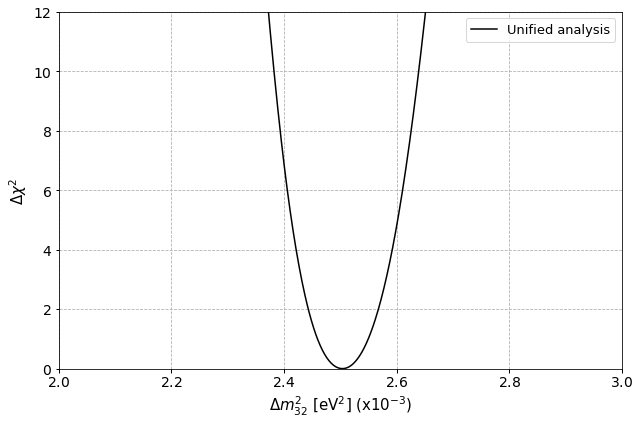

In [65]:
UNIFIED_dm32 = ploter_UNIFIED_profile(total_data,'dm32',3000)

In [66]:
sigma_unified= get_total_uncertainties(UNIFIED_dm32,'dm32')
for k in range(0,len(sigma_unified[0])):
    print(sigma_unified[0][k],sigma_unified[1][k])

0.001 1462.002546132369
0.001001300433477826 1459.3791582091146
0.001002600866955652 1456.7592531309597
0.0010039013004334778 1454.1428302063948
0.0010052017339113037 1451.5298887439094
0.0010065021673891297 1448.920428051995
0.0010078026008669557 1446.3144474391404
0.0010091030343447817 1443.7119462138378
0.0010104034678226075 1441.112923684577
0.0010117039013004335 1438.5173791598477
0.0010130043347782594 1435.9253119481407
0.0010143047682560854 1433.3367213579465
0.0010156052017339114 1430.751606697755
0.0010169056352117372 1428.1699672760576
0.0010182060686895632 1425.5918024013433
0.0010195065021673892 1423.017111382104
0.0010208069356452151 1420.4458935268285
0.0010221073691230411 1417.8781481440083
0.001023407802600867 1415.3138745421336
0.0010247082360786929 1412.7530720296943
0.0010260086695565189 1410.1957399151809
0.0010273091030343448 1407.6418775070842
0.0010286095365121708 1405.0914841138938
0.0010299099699899966 1402.5445590441018
0.0010312104034678226 1400.0011016061965

0.0029831610536845614 137.56116896062804
0.0029844614871623876 138.3325418738878
0.0029857619206402133 139.1061323722788
0.002987062354118039 139.8819446554406
0.0029883627875958653 140.65998292301288
0.002989663221073691 141.44025137463433
0.0029909636545515173 142.2227542099449
0.002992264088029343 143.0074956285833
0.002993564521507169 143.79447983018915
0.002994864954984995 144.58371101440207
0.002996165388462821 145.37519338086082
0.002997465821940647 146.1689311292053
0.0029987662554184728 146.9649284590742
0.0030000666888962985 147.76318956997747
0.0030013671223741247 148.56371754427042
0.0030026675558519505 149.366511631256
0.0030039679893297763 150.1715702588116
0.0030052684228076025 150.97889185481472
0.0030065688562854282 151.78847484714208
0.0030078692897632544 152.60031766367132
0.00300916972324108 153.41441873227933
0.003010470156718906 154.23077648084342
0.003011770590196732 155.04938933724117
0.003013071023674558 155.8702557293493
0.003014371457152384 156.69337408504535

0.004470856952317439 2082.910537002746
0.004472157385795265 2084.913355336672
0.0044734578192730905 2086.9149661779497
0.004474758252750916 2088.9153668846957
0.004476058686228743 2090.914554815024
0.004477359119706569 2092.9125273270474
0.004478659553184394 2094.9092817788815
0.004479959986662221 2096.904815528642
0.004481260420140047 2098.8991259344416
0.004482560853617873 2100.892210354396
0.004483861287095698 2102.884066146619
0.004485161720573524 2104.8746906692263
0.00448646215405135 2106.864081280333
0.004487762587529176 2108.8522353380517
0.004489063021007002 2110.8391502004997
0.004490363454484828 2112.8248232257893
0.004491663887962654 2114.8092517720356
0.0044929643214404805 2116.792433197355
0.004494264754918306 2118.77436485986
0.004495565188396132 2120.7550441176654
0.004496865621873958 2122.734468328886
0.0044981660553517835 2124.712634851637
0.004499466488829609 2126.6895410440334
0.004500766922307435 2128.6651850369917
0.004502067355785262 2130.6395770079307
0.00450336

In [67]:
min_value = 0.0025 
left_value = 0.0024590
right_value = 0.0025501
print((min_value-left_value,right_value-min_value))

(4.100000000000024e-05, 5.009999999999997e-05)


{'dm32_min': 0.0025, 's2_t13_min': 0.0225, 's2_t23_min': 0.5875, 'ji_min': 0.0}
{'new_min_after_interpolation': -0.0003424640144167673, 'min_nom_arfter_interp': 0.0}


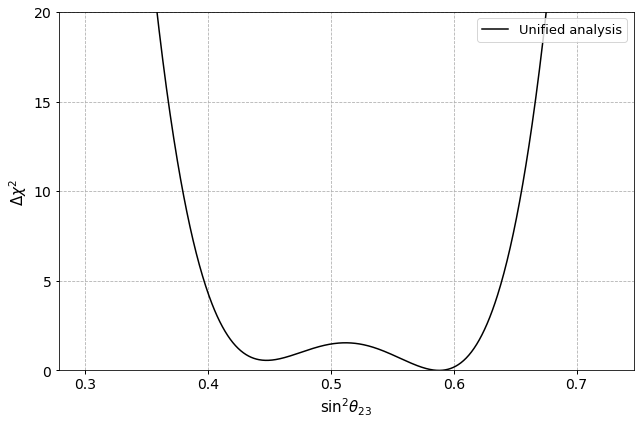

In [68]:
UNIFIED_s2_t23 = ploter_UNIFIED_profile(total_data,'s2_t23',1000)

In [69]:
sigma_unified= get_total_uncertainties(UNIFIED_s2_t23,'s2_t23')
for k in range(0,len(sigma_unified[0])):
    print(sigma_unified[0][k],sigma_unified[1][k])

0.3 82.31594187401443
0.30042542542542544 81.628325080076
0.30085085085085084 80.94474030635277
0.3012762762762763 80.26517451301436
0.3017017017017017 79.58961466023084
0.30212712712712714 78.91804770817183
0.30255255255255253 78.25046061700735
0.302977977977978 77.58684034690708
0.3034034034034034 76.92717385804102
0.30382882882882883 76.27144811057885
0.30425425425425423 75.61965006469057
0.3046796796796797 74.97176668054587
0.3051051051051051 74.32778491831475
0.30553053053053053 73.68769173816688
0.3059559559559559 73.05147410027222
0.3063813813813814 72.4191189648005
0.3068068068068068 71.79061329192173
0.3072322322322322 71.16594404180555
0.3076576576576576 70.54509817462197
0.3080830830830831 69.9280626505407
0.30850850850850847 69.31482442973167
0.3089339339339339 68.70537047236466
0.3093593593593593 68.09968773860959
0.3097847847847848 67.49776318863617
0.3102102102102102 66.89958378261431
0.3106356356356356 66.30513648071393
0.3110610610610611 65.71440824310473
0.31148648648

In [70]:
min_value =  0.5875
left_value = 0.54547047
right_value = 0.6143893
print((min_value-left_value,right_value-min_value))

(0.04202952999999998, 0.026889300000000005)


{'dm32_min': 0.0025, 's2_t13_min': 0.0225, 's2_t23_min': 0.5875, 'ji_min': 0.0}
{'new_min_after_interpolation': -0.11190220828039132, 'min_nom_arfter_interp': 0.0}


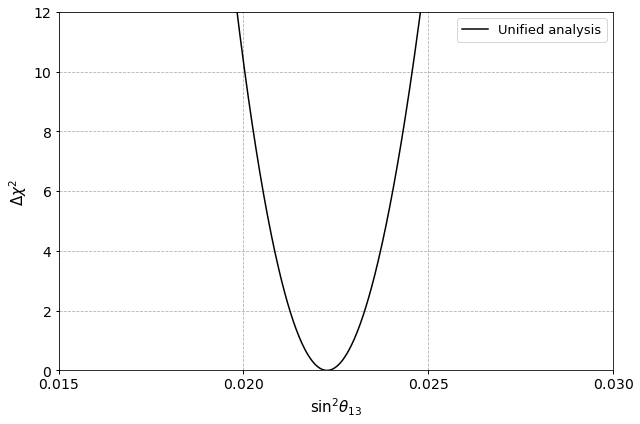

In [71]:
UNIFIED_s2_t13 = ploter_UNIFIED_profile(total_data,'s2_t13',3000)

In [72]:
sigma_unified= get_total_uncertainties(UNIFIED_s2_t13,'s2_t13')
for k in range(0,len(sigma_unified[0])):
    print(sigma_unified[0][k],sigma_unified[1][k])

0.0 1233.8219527975066
2.5841947315771924e-05 1230.9674638160484
5.168389463154385e-05 1228.1149465978995
7.752584194731577e-05 1225.2644093591482
0.0001033677892630877 1222.415860315884
0.00012920973657885962 1219.5693076841967
0.00015505168389463154 1216.7247596801733
0.00018089363121040348 1213.8822245199044
0.0002067355785261754 1211.0417104194778
0.0002325775258419473 1208.2032255949825
0.00025841947315771924 1205.3667782625084
0.00028426142047349116 1202.5323766381432
0.00031010336778926307 1199.7000289379766
0.000335945315105035 1196.8697433780983
0.00036178726242080695 1194.041528174595
0.00038762920973657886 1191.2153915435574
0.0004134711570523508 1188.3913417010745
0.0004393131043681227 1185.5693868632334
0.0004651550516838946 1182.749535246125
0.0004909969989996666 1179.9317950658376
0.0005168389463154385 1177.11617453846
0.0005426808936312104 1174.3026818800815
0.0005685228409469823 1171.4913253067903
0.0005943647882627542 1168.6821130346752
0.0006202067355785261 1165.8750

0.034447315771923975 240.93775754615817
0.03447315771923975 241.8679891071669
0.03449899966655552 242.79965299522956
0.03452484161387129 243.73274728060372
0.03455068356118706 244.66727003354782
0.034576525508502834 245.60321932431933
0.03460236745581861 246.5405932231761
0.03462820940313438 247.47938980037594
0.034654051350450146 248.41960712617654
0.03467989329776592 249.3612432708361
0.03470573524508169 250.30429630461228
0.034731577192397466 251.24876429776293
0.03475741913971324 252.1946453205458
0.03478326108702901 253.14193744321875
0.03480910303434478 254.09063873603932
0.03483494498166055 255.04074726926603
0.034860786928976324 255.99226111315622
0.0348866288762921 256.94517833796795
0.03491247082360787 257.8994970139588
0.034938312770923644 258.8552152113868
0.03496415471823941 259.8123310005094
0.03498999666555518 260.770842451585
0.035015838612870956 261.73074764420795
0.03504168056018673 262.6920447907801
0.0350675225075025 263.6547322025224
0.035093364454818275 264.618808

0.06385545181727242 1902.621373663461
0.06388129376458819 1904.4121302827673
0.06390713571190397 1906.2032239770651
0.06393297765921974 1907.9946543145047
0.06395881960653552 1909.7864208632413
0.06398466155385128 1911.5785231914253
0.06401050350116705 1913.37096086721
0.06403634544848283 1915.1637334587504
0.0640621873957986 1916.9568405341963
0.06408802934311437 1918.750281661703
0.06411387129043014 1920.5440564094208
0.06413971323774592 1922.3381643455039
0.06416555518506169 1924.1326050381044
0.06419139713237745 1925.9273780553744
0.06421723907969323 1927.7224829654695
0.064243081027009 1929.5179193365395
0.06426892297432478 1931.3136867367384
0.06429476492164055 1933.1097847342178
0.06432060686895631 1934.9062128971314
0.06434644881627209 1936.7029707936329
0.06437229076358786 1938.5000579918728
0.06439813271090364 1940.297474060006
0.0644239746582194 1942.0952185661836
0.06444981660553517 1943.893291078558
0.06447565855285095 1945.6916911652845
0.06450150050016672 1947.4904183945

In [73]:
min_value =  0.0225
left_value = 0.0215
right_value = 0.0229734
print((min_value-left_value,right_value-min_value))

(0.0010000000000000009, 0.0004734000000000023)


## Unificado ( 2D vs $\Delta \chi^2$ )

In [74]:
def ploter_UNIFIED_confidence_regions(df,params,size):
    
    df = get_interpolated_data_2D(df,params,size)
    
    cl_68 = df[ (df['ji']  <=  2.30)  & (df['ji']  >=  2.2) ]   # 68.27 C.L. 
    cl_90 = df[ (df['ji']  <=  4.61)  & (df['ji']  >=  4.51) ]
    #cl_95 = df[ (df['ji']  <=  6.18)  & (df['ji']  >=  6.05) ]   # 95.45 C.L.
    #cl_99 = df[ (df['ji']  <=  11.83) & (df['ji']  >=  11.65) ]  # 99.73 C.L.
    
    fig, ax = plt.subplots(figsize=(9,6))
    
    par =[]
    labels = []    
    if( ('dm32' in params) & ('s2_t13' in params) ):
        par.append('s2_t13')
        par.append('dm32')
        ax.set_xlim(0.018, 0.028)
        ax.set_xticks([0.018,0.02,0.022,0.024,0.026,0.028])
        ax.set_xticklabels(['$0.018$','$0.020$','$0.022$','$0.024$','$0.026$','$0.028$'])
        
        ax.set_ylim(0.002, 0.003)   
        ax.set_yticks([0.002,0.0022,0.0024,0.0026,0.0028,0.0030])
        ax.set_yticklabels(['$2.0$','$2.2$','$2.4$','$2.6$','$2.8$','$3.0$'])
        labels = [r'$\sin^2 \theta_{13}$',r'$\Delta m^2_{32}$'+' [eV$^2$] (x10$^{-3}$)']        
    elif( ('dm32' in params) & ('s2_t23' in params) ):
        par.append('s2_t23')
        par.append('dm32')     
        
        ax.set_xlim(0.3, 0.7)
        ax.set_xticks([0.3,0.4,0.5,0.6,0.7])
        ax.set_xticklabels(['$0.3$','$0.4$','$0.5$','$0.6$','$0.7$'])
        
        ax.set_ylim(0.002, 0.0030)   
        ax.set_yticks([0.002,0.0022,0.0024,0.0026,0.0028,0.0030])
        ax.set_yticklabels(['$2.0$','$2.2$','$2.4$','$2.6$','$2.8$','$3.0$'])
        
        labels = [r'$\sin^2 \theta_{23}$',r'$\Delta m^2_{32}$'+' [eV$^2$] (x10$^{-3}$)']
    elif( ('s2_t13' in params) & ('s2_t23' in params) ):
        par.append('s2_t13')
        par.append('s2_t23')        
        
        ax.set_xlim(0.018, 0.028)
        ax.set_xticks([0.018,0.02,0.022,0.024,0.026,0.028])
        ax.set_xticklabels(['$0.018$','$0.020$','$0.022$','$0.024$','$0.026$','$0.028$'])
        
        ax.set_ylim(0.3, 0.7)
        ax.set_yticks([0.3,0.4,0.5,0.6,0.7])
        ax.set_yticklabels(['$0.3$','$0.4$','$0.5$','$0.6$','$0.7$'])
        
        labels = [r'$\sin^2 \theta_{13}$',r'$\sin^2 \theta_{23}$']
    else:
        print('Opción no correcta')
    
    #ax.scatter(par[0], par[1], data=cl_99, c='black',s=0.5)
    #ax.scatter(par[0], par[1], data=cl_95, c='red',s=0.5)    
    ax.scatter(par[0], par[1], data=cl_90, c='black',s=0.5)
    ax.scatter(par[0], par[1], data=cl_68, c='blue',s=0.5)
    
    ax.set(xlabel=labels[0], ylabel=labels[1],  title='Unified analysis')
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)
    
    ax.tick_params(labelcolor='black', labelsize=13, width=1)
    
    ax.grid(True,linestyle='--')
    fig.savefig('images/plot_UNIFIED_'+par[0]+'_'+par[1]+ '_vs_ji.png')
    #return [cl_68,cl_95,cl_99]
    return [cl_68,cl_90]

{'dm32_min': 0.0025, 's2_t13_min': 0.0225, 's2_t23_min': 0.5875, 'ji_min': 0.0}
{'new_min_after_interpolation': -0.008681242871244199, 'min_nom_arfter_interp': 0.0}


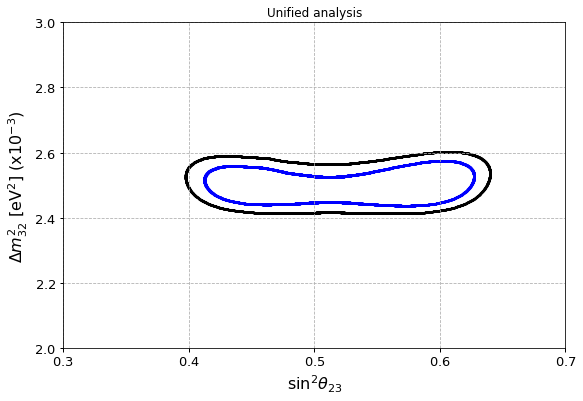

In [75]:
UNIFIED_dm32_s2_t23 = ploter_UNIFIED_confidence_regions(total_data,['dm32','s2_t23'],4800)

{'dm32_min': 0.0025, 's2_t13_min': 0.0225, 's2_t23_min': 0.5875, 'ji_min': 0.0}
{'new_min_after_interpolation': -0.128276957574831, 'min_nom_arfter_interp': 0.0}


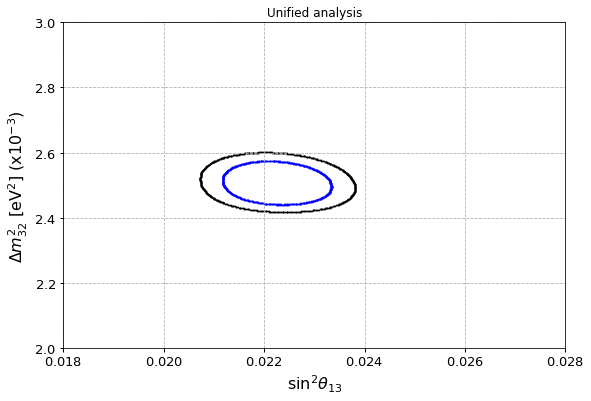

In [76]:
UNIFIED_dm32_s2_t13 = ploter_UNIFIED_confidence_regions(total_data,['dm32','s2_t13'],4800)

{'dm32_min': 0.0025, 's2_t13_min': 0.0225, 's2_t23_min': 0.5875, 'ji_min': 0.0}
{'new_min_after_interpolation': -0.11216305582835141, 'min_nom_arfter_interp': 0.0}


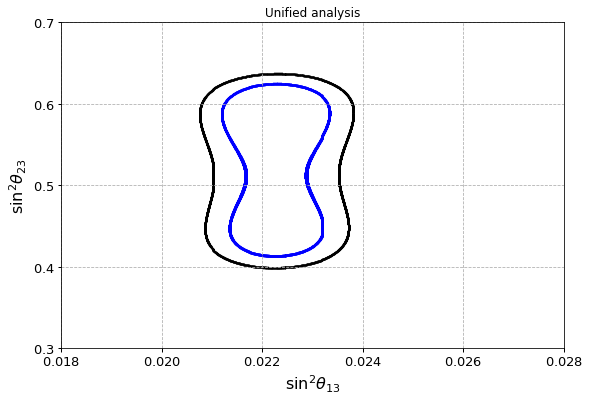

In [77]:
UNIFIED_s2_t13_s2_t23 = ploter_UNIFIED_confidence_regions(total_data,['s2_t23','s2_t13'],4000)

# Comparación de gráficas 1D

In [78]:
def ploter_all_profiles(minos,sk,db,reno,unified,param):    
    
    fig, ax = plt.subplots(figsize=(9,6))    
    
    labels=[]    
    if(param=='dm32'):
        ax.plot(param, 'ji', data=minos,label='MINOS')#,c='black')
        ax.plot(param, 'ji', data=sk,label='Super-Kamiokande')#,c='black')
        ax.plot(param, 'ji', data=db,label='Daya Bay')#,c='black')
        ax.plot(param, 'ji', data=reno,label='RENO')#,c='black')
        ax.plot(param, 'ji', data=unified,label='Global Analysis',c='black',linestyle='dashed')
        lgnd = plt.legend(loc="upper right",fontsize=13)
    
        ax.set_xlim(0.001, 0.005)
        ax.set_xticks([0.001,0.002,0.003,0.004,0.005])
        ax.set_xticklabels(['$1.0$','$2.0$','$3.0$','$4.0$','$5.0$'])
        
        ax.set_ylim(0, 20)   
        ax.set_yticks([0,5,10,15,20])
        ax.set_yticklabels(['$0$','$5$','$10$','$15$','$20$'])
        
        labels=[r'$\Delta m^2_{32}$ [eV$^2$] (x10$^{-3}$)',r'$\Delta \chi^2 $']
    elif(param=='s2_t13'):
        ax.plot(param, 'ji', data=minos,label='MINOS')#,c='black')
        ax.plot(param, 'ji', data=sk,label='Super-Kamiokande')#,c='black')
        ax.plot(param, 'ji', data=db,label='Daya Bay')#,c='black')
        ax.plot(param, 'ji', data=reno,label='RENO')#,c='black')
        ax.plot(param, 'ji', data=unified,label='Global Analysis',c='black',linestyle='dashed')
        lgnd = plt.legend(loc="upper right",fontsize=13)
        
        ax.set_ylim(0, 20)   
        ax.set_yticks([0,5,10,15,20])
        ax.set_yticklabels(['$0$','$5$','$10$','$15$','$20$'])
        
        ax.set_xlim(0.00, 0.07)
        ax.set_xticks([0.00,0.01,0.02,0.03,0.04,0.05,0.06,0.07])
        ax.set_xticklabels(['$0.0$','$0.01$','$0.02$','$0.03$','$0.04$','$0.05$','$0.06$','$0.07$'])
                
        labels=[r'$\sin^2 \theta_{13}$',r'$\Delta \chi^2 $']
    elif(param=='s2_t23'):
        ax.plot(param, 'ji', data=minos,label='MINOS')#,c='black')
        ax.plot(param, 'ji', data=sk,label='Super-Kamiokande')#,c='black')        
        ax.plot(param, 'ji', data=unified,label='Global Analysis',c='black',linestyle='dashed')
        lgnd = plt.legend(loc="upper right",fontsize=13)
        
        ax.set_xlim(0.3, 0.7)       
        
        ax.set_ylim(0, 20)   
        ax.set_yticks([0,5,10,15,20])
        ax.set_yticklabels(['$0$','$5$','$10$','$15$','$20$'])
        
        labels=[r'$\sin^2 \theta_{23}$',r'$\Delta \chi^2 $']
    else:
        print('Opción no de "param" es incorrecta')
        
    ax.tick_params(labelcolor='black', labelsize=14, width=1)
    
    ax.set(xlabel=labels[0], ylabel=labels[1])
    ax.xaxis.label.set_size(15)
    ax.yaxis.label.set_size(15)
    plt.tight_layout()
    ax.grid(True, linestyle='--')
    
    fig.savefig('images/plot_all_'+param+'_vs_ji.png')
    return  

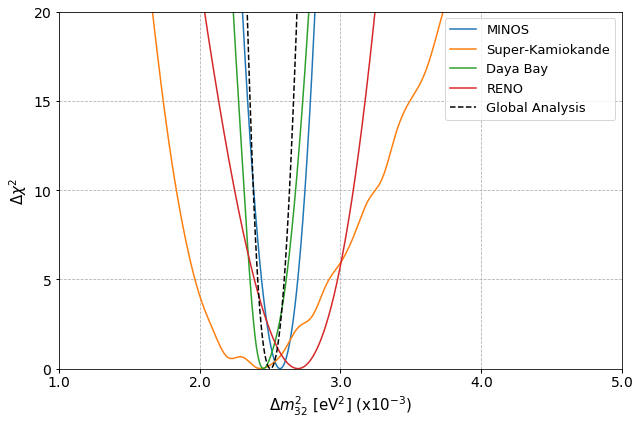

In [79]:
ploter_all_profiles(MINOS_dm32,SK_dm32,db_dm32,RENO_dm32,UNIFIED_dm32,'dm32')

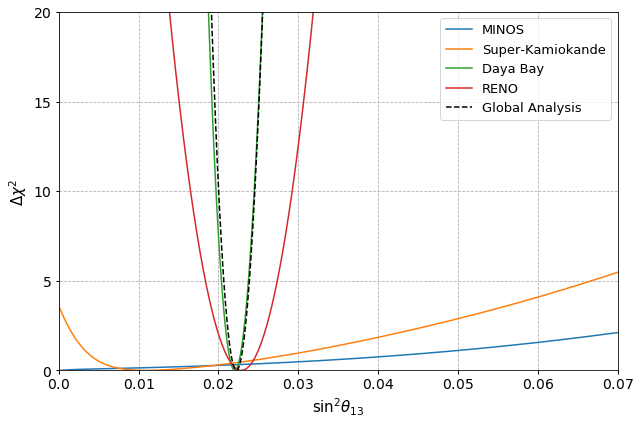

In [80]:
ploter_all_profiles(MINOS_s2_t13,SK_s2_t13,db_s2_t13,RENO_s2_t13,UNIFIED_s2_t13,'s2_t13')

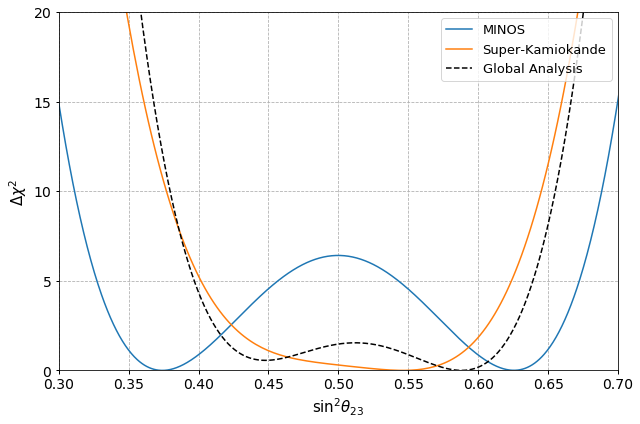

In [81]:
ploter_all_profiles(MINOS_s2_t23,SK_s2_t23,db_s2_t23,RENO_s2_t23,UNIFIED_s2_t23,'s2_t23')

# Comparación de gráficas 2D

In [235]:
def ploter_all_confidence_regions(minos,sk,reno,db,unified,params):    
    
    
    #cl_68 = df[ (df['ji']  <=  2.30)  & (df['ji']  >=  2.15) ]   # 68.27 C.L. 
    ##cl_90 = df[ (df['ji']  <=  4.61)  & (df['ji']  >=  4.51) ]
    #cl_95 = df[ (df['ji']  <=  6.18)  & (df['ji']  >=  6.05) ]   # 95.45 C.L.
    #cl_99 = df[ (df['ji']  <=  11.83) & (df['ji']  >=  11.65) ]  # 99.73 C.L.
    
    fig, ax = plt.subplots(figsize=(9,6))
    
    par =[]
    labels = []    
    if( ('dm32' in params) & ('s2_t13' in params) ):
        par.append('s2_t13')
        par.append('dm32')
        
        #ax.scatter(par[0], par[1], data=minos[1], c='red',s=0.1)
        #ax.scatter(par[0], par[1], data=minos[0], s=0.1, marker='*')
        ax.scatter(0.0, 0.0026, s=400, marker='*')
        
        #ax.scatter(par[0], par[1], data=sk[2], c='blue',s=0.1)
        #ax.scatter(par[0], par[1], data=sk[1], c='blue',s=0.1)
        #ax.scatter(par[0], par[1], data=sk[0],   s=0.1)
        ax.scatter(0.01,0.0024, s=400, marker='*')
        
        #ax.scatter(par[0], par[1], data=reno[2], c='green',s=0.1)
        #ax.scatter(par[0], par[1], data=reno[1], c='green',s=0.1)
        #ax.scatter(par[0], par[1], data=reno[0],s=1.0, marker='*') 
        ax.scatter(0.0225,0.0027, s=400, marker='*')
        
        #ax.scatter(par[0], par[1], data=db[2], c='green',s=0.1)
        #ax.scatter(par[0], par[1], data=db[1], c='green',s=0.1)
        #ax.scatter(par[0], par[1], data=db[0],s=1.0, marker='*')
        ax.scatter(0.0225,0.0025, s=600, marker='*', c='violet')
        
        #ax.scatter(par[0], par[1], data=unified[2], c='black',s=0.1)
        #ax.scatter(par[0], par[1], data=unified[1], c='black',s=0.1)
        ax.scatter(par[0], par[1], data=unified[0],s=1.0, c='black', marker='*')
        ax.scatter(0.0225,0.0025, s=30, c='black', marker='o')
        
        
        
        ax.set_xlim(0.005, 0.03)
        #ax.set_xticks([0.018,0.02,0.022,0.024,0.026,0.028])
        #ax.set_xticklabels(['$0.018$','$0.020$','$0.022$','$0.024$','$0.026$','$0.028$'])
        
        ax.set_ylim(0.00235, 0.00275)   
        ax.set_yticks([0.0024,0.0025,0.0026,0.00270])
        ax.set_yticklabels(['$2.4$','$2.5$','$2.6$','$2.7$'])
        labels = [r'$\sin^2 \theta_{13}$',r'$\Delta m^2_{32}$'+' [eV$^2$] (x10$^{-3}$)']        
    elif( ('dm32' in params) & ('s2_t23' in params) ):
        par.append('s2_t23')
        par.append('dm32')     
        
        ax.scatter(par[0], par[1], data=minos[1], c='darkcyan',s=0.3,label='MINOS')
        ax.scatter(par[0], par[1], data=minos[0], c='darkcyan',s=0.3,label='')
        
        #ax.scatter(par[0], par[1], data=sk[2], c='blue',s=0.1)
        ax.scatter(par[0], par[1], data=sk[1], c='m',s=0.3,label='Super-Kamiokande')
        ax.scatter(par[0], par[1], data=sk[0], c='m',s=0.3,label='')
        
        #ax.scatter(par[0], par[1], data=reno[2], c='green',s=0.1)
        #ax.scatter(par[0], par[1], data=reno[1], c='green',s=0.5)
        #ax.scatter(par[0], par[1], data=reno[0], c='green',s=3.0)
        
        #ax.scatter(par[0], par[1], data=db[2], c='green',s=0.1)
        #ax.scatter(par[0], par[1], data=db[1], c='green',s=0.5)
        #ax.scatter(par[0], par[1], data=db[0], c='green',s=3.0)
        
        #ax.scatter(par[0], par[1], data=unified[2], c='black',s=0.1)
        ax.scatter(par[0], par[1], data=unified[1], c='black',s=0.1,label='Global Analysis')
        ax.scatter(par[0], par[1], data=unified[0], c='black',s=0.1,label='')
        
        ax.scatter(0.375, 0.0026,  c='darkcyan',marker='*',s=80)
        
        ax.scatter(0.5875, 0.0025, c='black',   marker='*',s=80)
        
        ax.scatter(0.55, 0.0024,   c='m',    marker='*',s=80)
        
        ax.set_xlim(0.32, 0.68)
        ax.set_ylim(0.0019, 0.0030)   
        ax.set_yticks([0.002,0.0025,0.0030,0.003])
        ax.set_yticklabels(['$2.0$','$2.5$','$3.0$','$3.0$'])
        
        labels = [r'$\sin^2 \theta_{23}$',r'$\Delta m^2_{32}$'+' [eV$^2$] (x10$^{-3}$)']
        lgnd = plt.legend(loc="lower left",fontsize=13)    
        lgnd.legendHandles[0]._sizes = [30]
        lgnd.legendHandles[1]._sizes = [30]
        lgnd.legendHandles[2]._sizes = [30]
    elif( ('s2_t13' in params) & ('s2_t23' in params) ):
        par.append('s2_t13')
        par.append('s2_t23')        
        
        #ax.scatter(par[0], par[1], data=minos[1], c='black',s=0.5)
        #ax.scatter(par[0], par[1], data=minos[0], c='red',s=3.0)
        ax.scatter(0.0000, 0.375, c='red',marker='*',s=150.0,label='MINOS')
         
        #ax.scatter(par[0], par[1], data=sk[2], c='black',s=1.0)
        #ax.scatter(par[0], par[1], data=sk[1], c='gray',s=1.0)
        ax.scatter(par[0], par[1], data=sk[0], c='darkcyan',s=1.0,label='')
        ax.scatter(0.01, 0.55,  c='darkcyan',marker='*',s=150.0,label='Super-Kamiokande')       
        
        #ax.scatter(par[0], par[1], data=unified[2], c='black',s=0.1)
        #ax.scatter(par[0], par[1], data=unified[1], c='darkcyan',s=0.5)
        ax.scatter(par[0], par[1], data=unified[0], c='black',s=1.0,label='')
        ax.scatter(0.0225, 0.5875, marker='*', c='black',s=150.0,label='Global Analysis')
        
               
        ax.set_xlim(0.00, 0.05)
        ax.set_ylim(0.33, 0.65)        
        
        labels = [r'$\sin^2 \theta_{13}$',r'$\sin^2 \theta_{23}$']
        
        lgnd = plt.legend(loc="lower right",fontsize=15)    
        lgnd.legendHandles[0]._sizes = [80]
        lgnd.legendHandles[1]._sizes = [80]
        lgnd.legendHandles[2]._sizes = [80]
    else:
        print('Opción no correcta')
    
  
    
    ax.set(xlabel=labels[0], ylabel=labels[1])
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)
    
    ax.tick_params(labelcolor='black', labelsize=13, width=1)
    
    ax.grid(True,linestyle='--')
    fig.savefig('images/plot_all_'+par[0]+'_'+par[1]+ '_vs_ji.png')
    return

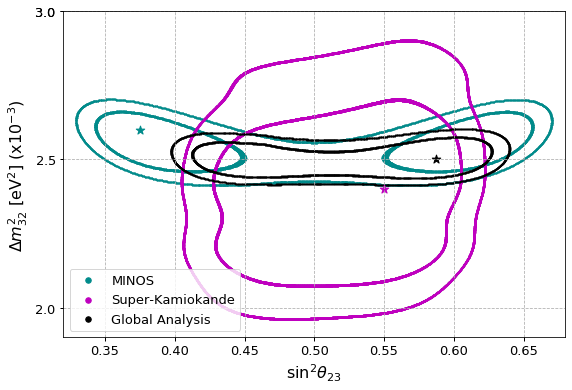

In [213]:
ploter_all_confidence_regions(MINOS_dm32_s2_t23,SK_dm32_s2_t23,RENO_dm32_s2_t23,db_dm32_s2_t23,UNIFIED_dm32_s2_t23,['dm32','s2_t23'])

In [214]:
MINOS_dm32_s2_t23[0].to_csv('MINOS_90_and_68.dat', sep=' ', header=False, index=False)
MINOS_dm32_s2_t23[1].to_csv('MINOS_90_and_90.dat', sep=' ', header=False, index=False)
#SK_dm32_s2_t23.to_csv()
#UNIFIED_dm32_s2_t23.to_csv()

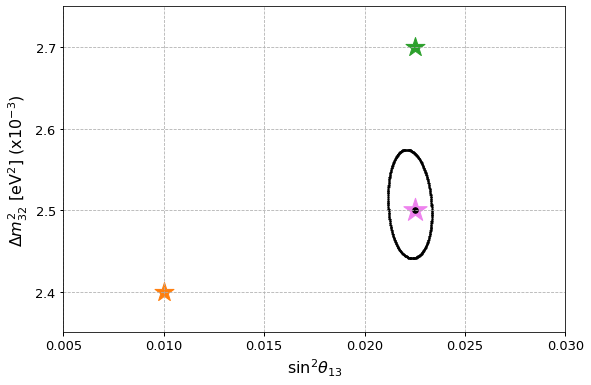

In [236]:
ploter_all_confidence_regions(MINOS_dm32_s2_t13,SK_dm32_s2_t13,RENO_dm32_s2_t13,db_dm32_s2_t13,UNIFIED_dm32_s2_t13,['dm32','s2_t13'])

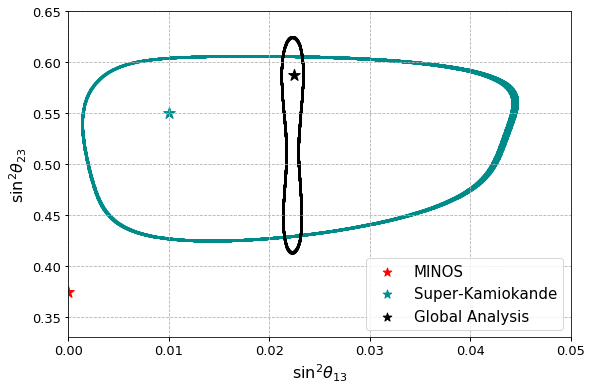

In [218]:
ploter_all_confidence_regions(MINOS_s2_t13_s2_t23,SK_s2_t13_s2_t23,db_s2_t13_s2_t23,RENO_s2_t13_s2_t23,UNIFIED_s2_t13_s2_t23,['s2_t23','s2_t13'])

# Otras gráficas

In [87]:
# DAYA BAY
db = pd.read_csv('daya_bay_nh_ih/db_comparition_68.dat', names=['s2_t13','dm32'], delim_whitespace=True)

# MINOS 
minos = pd.read_csv('minos_nh_ih/MINOS_comparition_68.dat', names=['s2_t13','dm32',], delim_whitespace=True)

# RENO
reno = pd.read_csv('reno_nh_ih/RENO_comparition_68.dat', names=['s2_t13','dm32'], delim_whitespace=True)

# SK
sk = pd.read_csv('sk_nh_ih/sk_comparition_68.dat', names=['s2_t13','dm32'], delim_whitespace=True)

# GB
gb = pd.read_csv('global_analysis_comparition_68.dat', names=['s2_t13','dm32'], delim_whitespace=True)

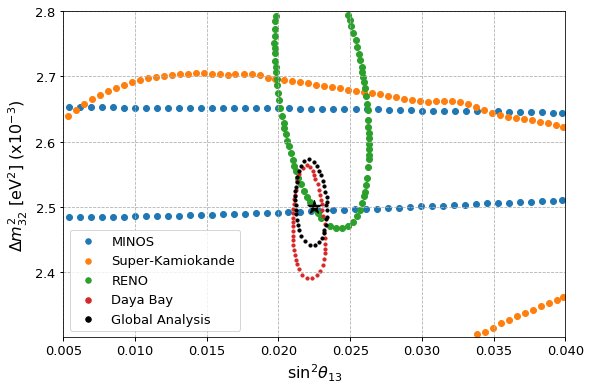

In [88]:
fig, ax = plt.subplots(figsize=(9,6))
    
labels = []       
        
        
ax.scatter('s2_t13', 'dm32', data=minos,marker='o',label='MINOS')
ax.scatter('s2_t13', 'dm32', data=sk,marker='o',label='Super-Kamiokande')             
ax.scatter('s2_t13', 'dm32', data=reno,marker='o',label='RENO')
ax.scatter('s2_t13', 'dm32', data=db,marker='o', s=10.0,label='Daya Bay')        
ax.scatter('s2_t13', 'dm32', data=gb,marker='o',s=10.0, c='black',label='Global Analysis')

#ax.scatter(0.0, 0.0026,    marker='*',s=100)#,                  label='MINOS')
#ax.scatter(0.01, 0.0024,   marker='*',s=100)#,                  label='Super-Kamiokande')             
#ax.scatter(0.0225, 0.0027, marker='*',s=100)#,                  label='RENO')
#ax.scatter(0.0225, 0.0025, marker='*',s=100)#,                  label='Daya Bay')        
ax.scatter(0.0225, 0.0025, marker='*',s=200, c='black')#,       label='Global Analysis')
        
ax.set_xlim(0.005, 0.04)

ax.set_ylim(0.0023, 0.0028)   
ax.set_yticks([0.0024,0.0025,0.0026,0.0027,0.0028])
ax.set_yticklabels(['$2.4$','$2.5$','$2.6$','$2.7$','$2.8$'])

labels = [r'$\sin^2 \theta_{13}$',r'$\Delta m^2_{32}$'+' [eV$^2$] (x10$^{-3}$)']
    
ax.set(xlabel=labels[0], ylabel=labels[1])
ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)
    
lgnd = plt.legend(loc="lower left",fontsize=13)    
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]
lgnd.legendHandles[2]._sizes = [30]
lgnd.legendHandles[3]._sizes = [30]
lgnd.legendHandles[4]._sizes = [30]

ax.tick_params(labelcolor='black', labelsize=13, width=1)
   
ax.grid(True,linestyle='--')
fig.savefig('images/plot_all_s2_t13_dm32_vs_ji.png') 

In [89]:
# MINOS 
minos = pd.read_csv('minos_nh_ih/MINOS_68_angles.dat', names=['s2_t13','s2_t23',], delim_whitespace=True)
# SK
sk = pd.read_csv('sk_nh_ih/sk_68_angles.dat', names=['s2_t13','s2_t23'], delim_whitespace=True)
# GB
gb = pd.read_csv('global_68_angles.dat', names=['s2_t13','s2_t23'], delim_whitespace=True)

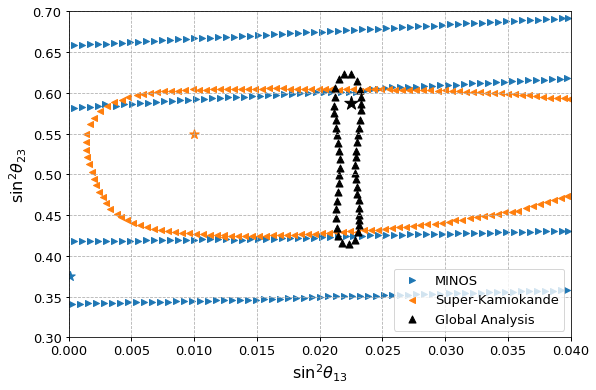

In [90]:
fig, ax = plt.subplots(figsize=(9,6))
    
par =[]
labels = []
        

ax.scatter('s2_t13', 's2_t23', data=minos, marker='>',label='MINOS')#,   c='black')#,s=3.0)
ax.scatter('s2_t13', 's2_t23', data=sk, marker='<',label='Super-Kamiokande')#,      c='gray')#,s=1.0)
ax.scatter('s2_t13', 's2_t23', data=gb, c='black', s=50.0, marker='^',label='Global Analysis')#, c='darkcyan')#,s=3.0)
 
ax.scatter( 0.0001,0.375,  marker='*',s=100, c='tab:blue')#,                  label='MINOS')
ax.scatter( 0.01,0.55,   marker='*',s=100, c='tab:orange')#,                  label='Super-Kamiokande')             
ax.scatter( 0.0225,0.5875, marker='*',s=200, c='black')#,       label='Global Analysis')    
    
ax.set_xlim(0.0, 0.04)
ax.set_ylim(0.30, 0.7)

labels = [r'$\sin^2 \theta_{13}$',r'$\sin^2 \theta_{23}$']
    
ax.set(xlabel=labels[0], ylabel=labels[1])
ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)

lgnd = plt.legend(loc="lower right",fontsize=13)    
ax.tick_params(labelcolor='black', labelsize=13, width=1)
    
ax.grid(True,linestyle='--')
fig.savefig('images/plot_all_s2_t13_s2_t23_vs_ji.png')